In [1]:
# #### run once before each notebook execution and clear output
# %pip install pandas_datareader 
# %pip install statsmodels
# %pip install linearmodels
# %pip install quantstats
# %pip install wrds
# %pip install pathlib
# %pip install scipy
# %pip install sklearn
# %pip install pandas_datareader 
# %pip install tqdm
# %pip install ZipFile
# %pip install seaborn
# %pip install matplotlib
# %pip install xgboost
# %pip install quandl
# %pip install keras
# %pip install --upgrade tensorflow 

# print('############################# completed installations #####################')

In [2]:
# after we install all the packages, import all of them for the use in today's lecture!
# database access
# import boto3
# from sagemaker import get_execution_role
# import s3fs
# import h5py
# import tempfile

import pandas_datareader as web
import quandl as quandl
import wrds as wrds
# storage and operations
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import seaborn as sns

# stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from scipy import stats
from scipy.stats.mstats import winsorize
import os
from tqdm import tqdm
from zipfile import ZipFile
import seaborn
import matplotlib.pyplot as plt
import linearmodels as lm
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

#portfolio optimization:
# libraries we might use for testing
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import linearmodels as lm
from linearmodels.panel import compare  
import time
import quantstats as qs
import tensorflow as tf
from tensorflow import keras
import xgboost

from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import gc

# path_factors = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\Factors')
# path_wrds = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\WRDS')
# path_ml = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Machine Learning Models')
# path_visual = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Visualisation/')
# path_betas = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\Factor Betas')

# factor_data = path_factors / 'factor_data.h5'
# macro_data = path_factors / 'macro_data.h5'
# wrds_data = path_wrds / 'wrds_data.h5'
# saved_models = path_ml / 'saved_ml_models.h5'

#bucket s3 AWS
path_bucket = 's3://mm-master-thesis-data/'
path_bucket_ml = 's3://mm-master-thesis-data/ml-models/'

#factor data 
factor_data = path_bucket + "monthly_factor_data.csv"
factor_data_adj = path_bucket + 'monthly_factors_adjusted.csv'
factor_data_base = path_bucket + 'monthly_factors_base.csv'
factor_data_base_extended = path_bucket + 'monthly_factors_base_extended.csv'

benchmark_ff = path_bucket + 'benchmark_factor_data.csv'
benchmark_bk = path_bucket + 'benchmark_factor_data_bkelly.csv'

#macro data 
macro_data = path_bucket + 'macro_data.csv'

# stock data
wrds_data_file = path_bucket +'wrds_data_complete_abs.csv' 
wrds_data_file_wins = path_bucket + 'monthly_wrds_data_complete_wins.csv'
wrds_data_file_wins_quin = path_bucket + 'monthly_stock_data_wins_quin.csv'
wrds_data_file_final = path_bucket + 'monthly_stock_data_final.csv'

#pca factors
pca_factor_path = path_bucket + 'monthly_pca_factors.csv'


# prediction results
OLS_df = path_bucket + 'ols_results.csv'
Ridge_df = path_bucket + 'ridge_results.csv'
Lasso_df = path_bucket + 'lasso_results.csv'

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
tf.version.VERSION

'2.8.0'

In [4]:
def file_saver(data_object, data_name_as_string):
    saver = boto3.Session().resource('s3').Bucket('mm-master-thesis-data').Object(data_object).upload_file(data_name_as_string)

In [5]:
def winsorizer(df, columns, limits):
    
    winsorized_df = df.copy(deep=True)
    for c in columns:
        goods    = winsorized_df[c].notna()
        winsorized_df.loc[goods,c] = winsorize(winsorized_df.loc[goods,c], limits=limits)

    return winsorized_df

def find_min_max(df, number_of_extremes, variable):
    if isinstance(df,pd.DataFrame):

        max_df_returns = df.max().tolist()
        max_df_returns.sort(reverse=True)
        number_max_returns = max_df_returns[:number_of_extremes]
        number_max_returns = [ '%.2f' % elem for elem in number_max_returns ]
        print('The', number_of_extremes, 'highest', variable, 'are: ') 
        print(number_max_returns)
        print('')
        min_df_returns = df.min().tolist()
        min_df_returns.sort()
        number_min_returns = min_df_returns[:number_of_extremes]
        number_min_returns = [ '%.2f' % elem for elem in number_min_returns ]
        print('The', number_of_extremes, 'lowest', variable, 'are: ') 
        print(number_min_returns)
    elif isinstance(df,pd.Series):
        max_df_returns = df.values.tolist()
        max_df_returns.sort(reverse=True)
        number_max_returns = max_df_returns[:number_of_extremes]
        number_max_returns = [ '%.2f' % elem for elem in number_max_returns ]
        print('The', number_of_extremes, 'highest', variable, 'are: ') 
        print(number_max_returns)
        print('')
        min_df_returns = df.values.tolist()
        min_df_returns.sort()
        number_min_returns = min_df_returns[:number_of_extremes]
        number_min_returns = [ '%.2f' % elem for elem in number_min_returns ]
        print('The', number_of_extremes, 'lowest', variable, 'are: ') 
        print(number_min_returns)

In [7]:
macro_factors = pd.read_csv(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\Factors\Macro Factors/macro_data.csv')
macro_factors = macro_factors.set_index('date',drop=True)
macro_factors = macro_factors.applymap(lambda x: f'{x:.3f}')
macro_factors = macro_factors.drop(columns=['Unnamed: 0'])
macro_factors = macro_factors.astype(float)
macro_factors

,D12,E12,bm,tbl,lty,ntis,Rfree,infl,ltr,corpr,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
date,,,,,,,,,,,,,,,,,,,,,
1977-07,4.407,10.517,0.897,0.052,0.077,0.033,0.004,0.005,-0.007,-0.001,...,85.536,35.172,24.873,5.97,7.54,5.58,12900.00,35574.00,230.302,15.362
1977-08,4.453,10.613,0.927,0.055,0.075,0.034,0.004,0.003,0.020,0.014,...,85.817,35.270,25.027,5.99,7.56,5.61,13058.00,36030.00,230.172,14.493
1977-09,4.500,10.710,0.942,0.058,0.076,0.032,0.004,0.003,-0.003,-0.002,...,85.946,35.317,25.173,6.03,7.62,5.65,13177.00,36241.00,230.965,14.087
1977-10,4.557,10.770,0.975,0.062,0.078,0.033,0.005,0.003,-0.009,-0.004,...,86.439,35.456,25.293,6.08,7.66,5.69,14686.00,37965.00,229.856,15.454
1977-11,4.613,10.830,0.962,0.061,0.078,0.029,0.005,0.005,0.009,0.006,...,86.802,35.699,25.434,6.11,7.68,5.72,14975.00,38553.00,231.645,19.638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08,59.129,98.557,0.236,0.001,0.006,-0.009,0.000,0.003,-0.035,-0.049,...,86.662,98.675,120.600,25.50,29.43,22.85,344023.25,726723.85,4385.243,22.879
2020-09,58.851,98.220,0.241,0.001,0.007,-0.006,0.000,0.001,0.008,0.004,...,86.616,98.508,120.964,25.46,29.11,23.00,347627.43,730734.42,4452.042,27.587
2020-10,58.660,96.857,0.253,0.001,0.008,-0.002,0.000,0.000,-0.024,-0.019,...,86.532,98.398,121.094,25.54,29.31,22.99,348262.68,730398.69,4514.528,29.436


In [8]:
display(macro_factors.describe().applymap(lambda x: f'{x:.3f}').T)

,count,mean,std,min,25%,50%,75%,max
D12,522.000,20.277,14.377,4.407,9.160,15.790,26.361,59.683
E12,522.000,47.410,35.250,6.860,16.415,34.841,78.653,139.470
bm,522.000,0.426,0.266,0.121,0.254,0.324,0.475,1.207
tbl,522.000,0.044,0.036,0.000,0.011,0.045,0.063,0.163
lty,522.000,0.064,0.032,0.006,0.041,0.060,0.085,0.148
...,...,...,...,...,...,...,...,...
CES3000000008,522.000,14.122,4.729,5.580,10.025,13.710,18.460,23.180
DTCOLNVHFNM,522.000,164020.699,109495.304,12900.000,67395.250,116693.560,275219.557,350766.100
DTCTHFNM,522.000,445474.704,303774.817,35574.000,157636.947,382710.740,734498.725,896985.060
INVEST,522.000,1485.633,1102.737,229.856,541.130,1100.616,2312.316,4685.876


# Factor Data

In [9]:
monthly_factors = pd.read_csv(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\Factors\Monthly Factors/monthly_factor_data.csv')
monthly_factors = monthly_factors.set_index('date',drop=True)
monthly_factors = monthly_factors.applymap(lambda x: f'{x:.3f}')
monthly_factors = monthly_factors.astype('float')
monthly_factors = monthly_factors.drop(columns=['Unnamed: 0','poa_y','rf']) 
monthly_factors = monthly_factors.rename(columns={'poa_x':'poa'})
monthly_factors = monthly_factors.loc[(monthly_factors.index>=('1977-01'))&(monthly_factors.index<=('2020-12'))]
monthly_factors

,0trade,abr_1,aci,adm,almq_1,amihud,atoq_1,bab,bm,bmj,...,ta,vfp,vhp,dtv_12,fp_6,iaq_12,p52w_6,r6_1,resid6,tbiq_12
date,,,,,,,,,,,,,,,,,,,,,
1977-07,0.019,-0.005,-0.021,0.013,-0.017,0.013,0.011,0.029,-0.011,-0.004,...,-0.006,0.009,-0.008,-0.011,-0.009,-0.007,0.008,-0.016,0.001,0.015
1977-08,-0.006,0.017,-0.004,-0.004,-0.017,0.001,0.018,0.003,-0.034,-0.033,...,0.016,-0.006,-0.030,-0.066,-0.025,0.017,-0.018,-0.012,-0.017,-0.003
1977-09,0.010,0.018,-0.003,-0.008,-0.005,0.012,-0.007,0.004,-0.002,-0.014,...,0.011,-0.010,0.019,-0.071,-0.022,0.005,0.022,0.025,0.007,0.013
1977-10,0.011,-0.007,-0.006,0.012,0.016,0.017,-0.000,0.002,0.014,0.019,...,0.007,-0.108,0.011,0.055,-0.008,0.000,0.010,-0.007,0.003,0.008
1977-11,-0.031,0.032,-0.010,0.001,0.024,0.041,0.007,0.003,0.011,0.004,...,0.004,0.029,0.004,-0.005,0.013,-0.014,-0.005,0.026,0.007,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08,-0.049,0.018,-0.011,0.000,0.009,-0.014,0.030,-0.040,-0.010,0.032,...,-0.001,-0.006,0.038,0.036,0.006,0.023,-0.011,-0.034,-0.025,0.022
2020-09,-0.006,0.006,-0.013,-0.010,-0.004,-0.005,0.011,0.013,-0.028,-0.063,...,0.020,-0.006,0.006,0.141,-0.018,0.012,0.049,0.043,-0.014,-0.030
2020-10,-0.012,-0.003,0.008,0.045,0.056,0.041,0.002,-0.020,0.025,0.043,...,-0.000,0.005,0.002,-0.036,0.003,-0.000,-0.027,-0.014,-0.006,-0.013


In [10]:
monthly_factors.describe().applymap(lambda x: f'{x:.3f}')

,0trade,abr_1,aci,adm,almq_1,amihud,atoq_1,bab,bm,bmj,...,ta,vfp,vhp,dtv_12,fp_6,iaq_12,p52w_6,r6_1,resid6,tbiq_12
count,522.000,522.000,522.000,522.000,522.000,522.000,522.000,522.000,522.000,522.000,...,522.000,522.000,522.000,522.000,522.000,522.000,522.000,522.000,522.000,522.000
mean,-0.001,0.007,-0.001,0.002,0.003,0.001,0.008,0.009,0.003,0.002,...,-0.001,0.001,0.002,-0.006,-0.005,-0.003,0.007,0.007,0.005,0.001
std,0.042,0.017,0.014,0.035,0.031,0.029,0.026,0.036,0.036,0.040,...,0.017,0.032,0.028,0.075,0.042,0.021,0.048,0.048,0.021,0.015
min,-0.287,-0.097,-0.086,-0.188,-0.136,-0.109,-0.080,-0.157,-0.184,-0.228,...,-0.081,-0.263,-0.164,-0.270,-0.188,-0.096,-0.365,-0.468,-0.133,-0.128
25%,-0.022,-0.002,-0.009,-0.016,-0.014,-0.016,-0.007,-0.005,-0.017,-0.021,...,-0.010,-0.016,-0.012,-0.035,-0.024,-0.016,-0.013,-0.010,-0.005,-0.007
50%,-0.003,0.008,-0.002,0.003,0.004,0.001,0.007,0.011,0.003,0.001,...,0.000,0.000,0.002,-0.007,-0.007,-0.002,0.010,0.011,0.005,0.002
75%,0.019,0.017,0.007,0.023,0.021,0.019,0.025,0.026,0.024,0.024,...,0.010,0.018,0.015,0.022,0.013,0.011,0.031,0.028,0.016,0.010
max,0.227,0.107,0.071,0.140,0.168,0.150,0.091,0.154,0.159,0.155,...,0.058,0.125,0.124,0.578,0.316,0.068,0.175,0.224,0.081,0.057


In [20]:
monthly_factors.values.mean()

0.0021425215065423264

### Checking for extreme values and winsorize them for better prediction results

In [11]:
find_min_max(monthly_factors, 20, 'factor returns')

The 20 highest factor returns are: 
['0.58', '0.34', '0.32', '0.31', '0.30', '0.29', '0.29', '0.28', '0.28', '0.27', '0.25', '0.24', '0.23', '0.22', '0.21', '0.19', '0.18', '0.18', '0.18', '0.18']

The 20 lowest factor returns are: 
['-0.47', '-0.36', '-0.34', '-0.31', '-0.31', '-0.29', '-0.29', '-0.27', '-0.27', '-0.27', '-0.26', '-0.26', '-0.26', '-0.24', '-0.23', '-0.23', '-0.23', '-0.23', '-0.23', '-0.22']


In [12]:
vars2wins_factors = monthly_factors.columns.values.tolist()
monthly_factors_wins = winsorizer(monthly_factors, vars2wins_factors, 0.005)
monthly_factors_wins.describe().applymap(lambda x: f'{x:.3f}')

,0trade,abr_1,aci,adm,almq_1,amihud,atoq_1,bab,bm,bmj,...,ta,vfp,vhp,dtv_12,fp_6,iaq_12,p52w_6,r6_1,resid6,tbiq_12
count,522.000,522.000,522.000,522.000,522.000,522.000,522.000,522.000,522.000,522.000,...,522.000,522.000,522.000,522.000,522.000,522.000,522.000,522.000,522.000,522.000
mean,-0.001,0.007,-0.001,0.003,0.003,0.001,0.008,0.009,0.003,0.002,...,-0.001,0.001,0.002,-0.007,-0.005,-0.003,0.007,0.007,0.005,0.001
std,0.039,0.016,0.014,0.034,0.031,0.028,0.026,0.035,0.035,0.039,...,0.017,0.030,0.027,0.069,0.041,0.020,0.045,0.042,0.020,0.013
min,-0.135,-0.042,-0.045,-0.130,-0.114,-0.082,-0.067,-0.134,-0.114,-0.155,...,-0.057,-0.125,-0.106,-0.242,-0.157,-0.060,-0.208,-0.230,-0.081,-0.048
25%,-0.022,-0.002,-0.009,-0.016,-0.014,-0.016,-0.007,-0.005,-0.017,-0.021,...,-0.010,-0.016,-0.012,-0.035,-0.024,-0.016,-0.013,-0.010,-0.005,-0.007
50%,-0.003,0.008,-0.002,0.003,0.004,0.001,0.007,0.011,0.003,0.001,...,0.000,0.000,0.002,-0.007,-0.007,-0.002,0.010,0.011,0.005,0.002
75%,0.019,0.017,0.007,0.023,0.021,0.019,0.025,0.026,0.024,0.024,...,0.010,0.018,0.015,0.022,0.013,0.011,0.031,0.028,0.016,0.010
max,0.154,0.059,0.047,0.118,0.117,0.102,0.080,0.130,0.118,0.133,...,0.045,0.102,0.094,0.304,0.219,0.049,0.133,0.145,0.066,0.043


In [13]:
find_min_max(monthly_factors_wins, 20, 'factor returns')

The 20 highest factor returns are: 
['0.30', '0.25', '0.23', '0.22', '0.20', '0.17', '0.16', '0.15', '0.15', '0.15', '0.15', '0.15', '0.15', '0.15', '0.15', '0.14', '0.14', '0.14', '0.14', '0.14']

The 20 lowest factor returns are: 
['-0.24', '-0.23', '-0.22', '-0.21', '-0.20', '-0.17', '-0.17', '-0.16', '-0.16', '-0.16', '-0.16', '-0.15', '-0.15', '-0.15', '-0.15', '-0.14', '-0.14', '-0.14', '-0.14', '-0.14']


In [15]:
# ################################################# saving ###################################################
# monthly_factors_wins.to_csv('monthly_factors_wins.csv')
# file_saver('monthly_factors_wins.csv','monthly_factors_wins.csv')
# #############################################################################################################

## Stock Data 

In [14]:
monthly_stock_data = pd.read_csv(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\WRDS/wrds_data_complete_abs.csv')
monthly_stock_data = monthly_stock_data.sort_values(['date','permno'])
monthly_stock_data = monthly_stock_data.set_index('date',drop=True)
monthly_stock_data = monthly_stock_data.astype(float) 
monthly_stock_data = monthly_stock_data.loc[monthly_stock_data.index>=('1977-07')]
monthly_stock_data = monthly_stock_data.dropna()   #unfortunately the last date 31.12.2020 gets removed since there is no forward return available
monthly_stock_data.applymap(lambda x: f'{x:.3f}')

,permno,prc,ret,shrout,mktcap,vweights,ret_mk,monthly_exret,fwd_monthly_exret
date,,,,,,,,,
1977-07,10057.000,12.875,0.084,4410.000,56778.750,0.000,-0.012,0.096,-0.001
1977-07,10065.000,12.125,0.000,14548.000,176394.500,0.000,-0.012,0.012,-0.004
1977-07,10137.000,21.875,0.017,27292.000,597012.500,0.001,-0.012,0.029,-0.016
1977-07,10145.000,47.625,-0.047,28089.000,1337738.625,0.002,-0.012,-0.036,-0.097
1977-07,10154.000,5.062,-0.069,1416.000,7168.500,0.000,-0.012,-0.057,-0.142
...,...,...,...,...,...,...,...,...,...
2020-11,92685.000,15.850,0.271,7610.000,120618.503,0.000,0.122,0.149,-0.069
2020-11,92688.000,2.210,0.195,4439.000,9810.190,0.000,0.122,0.072,-0.114
2020-11,92690.000,14.330,0.065,41710.000,597704.297,0.000,0.122,-0.058,-0.013


In [15]:
monthly_stock_data.describe().applymap(lambda x: f'{x:.3f}')

,permno,prc,ret,shrout,mktcap,vweights,ret_mk,monthly_exret,fwd_monthly_exret
count,2175824.000,2175824.000,2175824.000,2175824.000,2175824.000,2175824.000,2175824.000,2175824.000,2175824.000
mean,61452.579,44.260,0.013,72315.672,2782225.730,0.000,0.016,-0.003,-0.003
std,26364.499,1885.118,0.152,314860.548,16230304.751,0.001,0.044,0.146,0.147
min,10001.000,0.015,-0.994,1.000,3.719,0.000,-0.207,-1.067,-1.067
25%,40483.000,7.062,-0.051,5368.000,46779.196,0.000,-0.011,-0.064,-0.064
50%,72996.000,15.550,0.005,15360.000,203560.042,0.000,0.018,-0.010,-0.010
75%,83452.000,30.375,0.063,46732.000,989447.729,0.000,0.043,0.044,0.044
max,93316.000,343688.000,24.000,29206400.000,2206911130.616,0.062,0.135,23.996,23.996


In [16]:
len(monthly_stock_data.permno.unique())

8146

In [17]:
find_min_max(monthly_stock_data['ret'],10,'returns')
print('')
find_min_max(monthly_stock_data['monthly_exret'],10,'monthly_exret')
print('')
find_min_max(monthly_stock_data['fwd_monthly_exret'],10,'fwd_monthly_exret')
print('')
find_min_max(monthly_stock_data['mktcap'],10,'mktcap')


The 10 highest returns are: 
['24.00', '19.00', '14.46', '13.50', '10.34', '9.37', '8.34', '7.48', '7.01', '7.00']

The 10 lowest returns are: 
['-0.99', '-0.98', '-0.97', '-0.96', '-0.95', '-0.95', '-0.95', '-0.94', '-0.94', '-0.93']

The 10 highest monthly_exret are: 
['24.00', '18.96', '14.43', '13.41', '10.27', '9.30', '8.32', '7.47', '6.97', '6.89']

The 10 lowest monthly_exret are: 
['-1.07', '-1.03', '-0.99', '-0.97', '-0.97', '-0.96', '-0.95', '-0.95', '-0.95', '-0.94']

The 10 highest fwd_monthly_exret are: 
['24.00', '18.96', '14.43', '13.41', '12.48', '11.06', '10.27', '9.30', '8.32', '7.47']

The 10 lowest fwd_monthly_exret are: 
['-1.07', '-1.03', '-0.99', '-0.97', '-0.97', '-0.96', '-0.96', '-0.96', '-0.95', '-0.95']

The 10 highest mktcap are: 
['2206911130.62', '2024064579.99', '1966078881.58', '1850816176.10', '1817315511.89', '1728551334.83', '1706732771.85', '1618475434.09', '1590936133.85', '1589567257.64']

The 10 lowest mktcap are: 
['3.72', '3.72', '4.16', '4.16'

# Data Preprocessing: Winsorizing the stock data at the 0.5% level

In [18]:
vars2wins_stocks = ['ret','monthly_exret','fwd_monthly_exret']
monthly_stock_data_wins = winsorizer(monthly_stock_data, vars2wins_stocks, 0.01)
monthly_stock_data_wins.describe().applymap(lambda x: f'{x:.3f}')

,permno,prc,ret,shrout,mktcap,vweights,ret_mk,monthly_exret,fwd_monthly_exret
count,2175824.000,2175824.000,2175824.000,2175824.000,2175824.000,2175824.000,2175824.000,2175824.000,2175824.000
mean,61452.579,44.260,0.011,72315.672,2782225.730,0.000,0.016,-0.005,-0.005
std,26364.499,1885.118,0.126,314860.548,16230304.751,0.001,0.044,0.118,0.118
min,10001.000,0.015,-0.336,1.000,3.719,0.000,-0.207,-0.328,-0.329
25%,40483.000,7.062,-0.051,5368.000,46779.196,0.000,-0.011,-0.064,-0.064
50%,72996.000,15.550,0.005,15360.000,203560.042,0.000,0.018,-0.010,-0.010
75%,83452.000,30.375,0.063,46732.000,989447.729,0.000,0.043,0.044,0.044
max,93316.000,343688.000,0.485,29206400.000,2206911130.616,0.062,0.135,0.450,0.451


In [19]:
find_min_max(monthly_stock_data_wins['ret'],10,'returns')
print('')
find_min_max(monthly_stock_data_wins['monthly_exret'],10,'monthly_exret')
print('')
find_min_max(monthly_stock_data_wins['fwd_monthly_exret'],10,'fwd_monthly_exret')
print('')
find_min_max(monthly_stock_data_wins['mktcap'],10,'mktcap')


The 10 highest returns are: 
['0.48', '0.48', '0.48', '0.48', '0.48', '0.48', '0.48', '0.48', '0.48', '0.48']

The 10 lowest returns are: 
['-0.34', '-0.34', '-0.34', '-0.34', '-0.34', '-0.34', '-0.34', '-0.34', '-0.34', '-0.34']

The 10 highest monthly_exret are: 
['0.45', '0.45', '0.45', '0.45', '0.45', '0.45', '0.45', '0.45', '0.45', '0.45']

The 10 lowest monthly_exret are: 
['-0.33', '-0.33', '-0.33', '-0.33', '-0.33', '-0.33', '-0.33', '-0.33', '-0.33', '-0.33']

The 10 highest fwd_monthly_exret are: 
['0.45', '0.45', '0.45', '0.45', '0.45', '0.45', '0.45', '0.45', '0.45', '0.45']

The 10 lowest fwd_monthly_exret are: 
['-0.33', '-0.33', '-0.33', '-0.33', '-0.33', '-0.33', '-0.33', '-0.33', '-0.33', '-0.33']

The 10 highest mktcap are: 
['2206911130.62', '2024064579.99', '1966078881.58', '1850816176.10', '1817315511.89', '1728551334.83', '1706732771.85', '1618475434.09', '1590936133.85', '1589567257.64']

The 10 lowest mktcap are: 
['3.72', '3.72', '4.16', '4.16', '4.38', '4.38',

In [21]:
# ################################################ saving ###################################################
# monthly_stock_data_wins.to_csv('monthly_wrds_data_complete_wins.csv')
# file_saver('monthly_wrds_data_complete_wins.csv','monthly_wrds_data_complete_wins.csv')
# #############################################################################################################

## Identify S&P 500 stocks

In [22]:
component_list = pd.read_csv(path_bucket+'sp500_permnos.csv')
component_list.drop(columns=['Unnamed: 0'], inplace=True)
component_list =  component_list.rename(columns={'0':'permno'})
component_list
sp_data_wins = monthly_stock_data_wins.loc[monthly_stock_data_wins.permno.isin(component_list.permno.unique())]
sp_data_wins

,permno,prc,ret,shrout,mktcap,vweights,ret_mk,monthly_exret,fwd_monthly_exret
date,,,,,,,,,
1977-07,10145.0,47.625000,-0.047500,28089.0,1.337739e+06,0.001761,-0.011797,-0.035703,-0.096826
1977-07,10516.0,19.250000,0.092199,29788.0,5.734190e+05,0.000882,-0.011797,0.103995,0.045548
1977-07,11308.0,39.125000,0.050336,122182.0,4.780371e+06,0.007207,-0.011797,0.062132,0.022561
1977-07,11404.0,23.625000,-0.030769,61583.0,1.454898e+06,0.002033,-0.011797,-0.018972,-0.030451
1977-07,11674.0,17.250000,0.007299,54268.0,9.361230e+05,0.001359,-0.011797,0.019096,-0.015153
...,...,...,...,...,...,...,...,...,...
2020-11,92402.0,409.420013,0.172536,82895.0,3.393887e+07,0.000947,0.122104,0.050432,0.044089
2020-11,92602.0,75.750000,0.066601,1557316.0,1.179667e+08,0.003298,0.122104,-0.055503,0.062228
2020-11,92611.0,210.350006,0.159375,1692384.0,3.559930e+08,0.009489,0.122104,0.037271,-0.006713


In [23]:
len(sp_data_wins.permno.unique())

501

# Creation of price Quintiles

In [26]:
def quintile_function(df, column_name, quintile, goal):

    if goal=='label': 
        
        quintile_df = pd.DataFrame(index=df.index)
        quintile_df['quintile'] = 1
        quintile_df_test = pd.DataFrame()
        data = df[column_name]
        quintile_column = df[column_name] 
        threshold_left = pd.qcut(df[column_name], quintile).cat.categories.left.astype(float).to_frame().reset_index(drop=True)
        threshold_left = threshold_left.rename(columns={0:'left'})
        threshold_right = pd.qcut(df[column_name], quintile).cat.categories.right.astype(float).to_frame().reset_index(drop=True)
        threshold_right = threshold_right.rename(columns={0:'right'})
        interval_df = pd.concat([threshold_left,threshold_right],axis=1)
        interval_df = interval_df.rename(index={0:1,1:2,2:3,3:4,4:5})
        
        for i in range(len(data)):
            if  interval_df.loc[1,'left'] <= df[column_name].iloc[i] <= interval_df.loc[1,'right']:
                quintile_df['quintile'].iloc[i] = float(1)
            if  interval_df.loc[2,'left'] <= df[column_name].iloc[i] <= interval_df.loc[2,'right']:
                quintile_df['quintile'].iloc[i] = float(2)
            if  interval_df.loc[3,'left'] <= df[column_name].iloc[i] <= interval_df.loc[3,'right']:
                quintile_df['quintile'].iloc[i] = float(3)
            if  interval_df.loc[4,'left'] <= df[column_name].iloc[i] <= interval_df.loc[4,'right']:
                quintile_df['quintile'].iloc[i] = float(4)
            if  interval_df.loc[5,'left'] <= df[column_name].iloc[i] <= interval_df.loc[5,'right']:
                quintile_df['quintile'].iloc[i] = float(5)
        return quintile_df
            
            
    elif goal=='get_interval':
        threshold_left = pd.qcut(df[column_name], quintile).cat.categories.left.astype(float).to_frame().reset_index(drop=True)
        threshold_left = threshold_left.rename(columns={0:'left'})
        threshold_right = pd.qcut(df[column_name], quintile).cat.categories.right.astype(float).to_frame().reset_index(drop=True)
        threshold_right = threshold_right.rename(columns={0:'right'})
        interval_df = pd.concat([threshold_left,threshold_right],axis=1)
        interval_df = interval_df.rename(index={0:1,1:2,2:3,3:4,4:5})
        return interval_df
        

In [27]:
from tqdm import tqdm
tqdm.pandas()

monthly_stock_data_wins_quin = monthly_stock_data_wins.copy(deep=True)
monthly_stock_data_wins_quin.reset_index(inplace=True)
quintiles_for_df = monthly_stock_data_wins_quin.groupby(monthly_stock_data_wins_quin.date).progress_apply(lambda x: quintile_function(x,'prc',5,'label')).reset_index(drop=True)
monthly_stock_data_wins_quin.reset_index(inplace=True)
monthly_stock_data_wins_quin = pd.concat([monthly_stock_data_wins_quin,quintiles_for_df],axis=1)
display(monthly_stock_data_wins_quin)


monthly_stock_data_wins_quin.reset_index(inplace=True)
quintile_borders = monthly_stock_data_wins_quin.groupby(monthly_stock_data_wins_quin.date).progress_apply(lambda x: quintile_function(x,'prc',5,'get_interval'))
display(quintile_borders)

100%|██████████| 521/521 [07:16<00:00,  1.19it/s]


,index,date,permno,prc,ret,shrout,mktcap,vweights,ret_mk,monthly_exret,fwd_monthly_exret,quintile
0,0,1977-07,10057.0,12.875000,0.084211,4410.0,5.677875e+04,8.262171e-05,-0.011797,0.096007,-0.001181,3
1,1,1977-07,10065.0,12.125000,0.000000,14548.0,1.763945e+05,2.590650e-04,-0.011797,0.011797,-0.003723,3
2,2,1977-07,10137.0,21.875000,0.017442,27292.0,5.970125e+05,9.767159e-04,-0.011797,0.029239,-0.016271,4
3,3,1977-07,10145.0,47.625000,-0.047500,28089.0,1.337739e+06,1.761113e-03,-0.011797,-0.035703,-0.096826,5
4,4,1977-07,10154.0,5.062500,-0.068966,1416.0,7.168500e+03,9.061844e-06,-0.011797,-0.057169,-0.141562,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2175819,2175819,2020-11,92685.0,15.850000,0.271051,7610.0,1.206185e+05,3.017645e-06,0.122104,0.148947,-0.068633,2
2175820,2175820,2020-11,92688.0,2.210000,0.194595,4439.0,9.810190e+03,3.161534e-07,0.122104,0.072491,-0.114425,1
2175821,2175821,2020-11,92690.0,14.330000,0.064563,41710.0,5.977043e+05,1.580327e-05,0.122104,-0.057540,-0.013055,2
2175822,2175822,2020-11,92807.0,3.280000,0.188406,17059.0,5.595352e+04,1.366077e-06,0.122104,0.066302,-0.092283,1


100%|██████████| 521/521 [00:03<00:00, 166.31it/s]


left       right
date                         
1977-07 1   0.218       4.625
        2   4.625      10.000
        3  10.000      17.375
        4  17.375      26.100
        5  26.100     268.125
...           ...         ...
2020-11 1   0.169       8.514
        2   8.514      17.084
        3  17.084      37.434
        4  37.434      78.810
        5  78.810  343688.000

[2605 rows x 2 columns]

In [30]:
monthly_stock_data_wins_quin = monthly_stock_data_wins_quin.drop(columns=['level_0','index'])
monthly_stock_data_wins_quin['fwd_quintile'] = monthly_stock_data_wins_quin.groupby('permno')['quintile'].apply(lambda x: x.shift(-1))
monthly_stock_data_wins_quin.dropna(inplace=True)
monthly_stock_data_wins_quin['fwd_quintile'] = monthly_stock_data_wins_quin['fwd_quintile'].astype(int)
monthly_stock_data_wins_quin = monthly_stock_data_wins_quin.sort_values(['permno','date'])

In [33]:
########################################################  saving  ###################
monthly_stock_data_wins_quin.to_csv('monthly_stock_data_wins_quin.csv')
file_saver('monthly_stock_data_wins_quin.csv','monthly_stock_data_wins_quin.csv')
######################################################################################

In [34]:
########################################################  saving  ###################
quintile_borders.to_csv('monthly_quintile_borders.csv')
file_saver('monthly_quintile_borders.csv','monthly_quintile_borders.csv')
#######################################################################################

In [35]:
len(monthly_stock_data_wins_quin.permno.unique())

8146

In [36]:
from tqdm import tqdm
tqdm.pandas()

sp_data_wins_quin = sp_data_wins.copy(deep=True)
sp_data_wins_quin.reset_index(inplace=True)
sp_quintiles_for_df = sp_data_wins_quin.groupby(sp_data_wins_quin.date).progress_apply(lambda x: quintile_function(x,'prc',5,'label')).reset_index(drop=True)
sp_data_wins_quin.reset_index(inplace=True)
sp_data_wins_quin = pd.concat([sp_data_wins_quin,sp_quintiles_for_df],axis=1)
display(sp_data_wins_quin)


sp_data_wins_quin.reset_index(inplace=True)
sp_quintile_borders =  sp_data_wins_quin.groupby(sp_data_wins_quin.date).progress_apply(lambda x: quintile_function(x,'prc',5,'get_interval'))
display(sp_quintile_borders)

100%|██████████| 521/521 [00:43<00:00, 12.08it/s]


,index,date,permno,prc,ret,shrout,mktcap,vweights,ret_mk,monthly_exret,fwd_monthly_exret,quintile
0,0,1977-07,10145.0,47.625000,-0.047500,28089.0,1.337739e+06,0.001761,-0.011797,-0.035703,-0.096826,5
1,1,1977-07,10516.0,19.250000,0.092199,29788.0,5.734190e+05,0.000882,-0.011797,0.103995,0.045548,2
2,2,1977-07,11308.0,39.125000,0.050336,122182.0,4.780371e+06,0.007207,-0.011797,0.062132,0.022561,5
3,3,1977-07,11404.0,23.625000,-0.030769,61583.0,1.454898e+06,0.002033,-0.011797,-0.018972,-0.030451,3
4,4,1977-07,11674.0,17.250000,0.007299,54268.0,9.361230e+05,0.001359,-0.011797,0.019096,-0.015153,2
...,...,...,...,...,...,...,...,...,...,...,...,...
200889,200889,2020-11,92402.0,409.420013,0.172536,82895.0,3.393887e+07,0.000947,0.122104,0.050432,0.044089,5
200890,200890,2020-11,92602.0,75.750000,0.066601,1557316.0,1.179667e+08,0.003298,0.122104,-0.055503,0.062228,3
200891,200891,2020-11,92611.0,210.350006,0.159375,1692384.0,3.559930e+08,0.009489,0.122104,0.037271,-0.006713,5
200892,200892,2020-11,92614.0,153.380005,0.022723,181272.0,2.780350e+07,0.000712,0.122104,-0.099381,-0.045964,4


100%|██████████| 521/521 [00:02<00:00, 204.05it/s]


left     right
date                        
1977-07 1    0.999    16.450
        2   16.450    21.825
        3   21.825    27.875
        4   27.875    37.750
        5   37.750   268.125
...            ...       ...
2020-11 1    1.399    34.080
        2   34.080    62.980
        3   62.980   113.970
        4  113.970   195.190
        5  195.190  3997.180

[2605 rows x 2 columns]

In [37]:
sp_data_wins_quin = sp_data_wins_quin.drop(columns=['level_0','index'])
sp_data_wins_quin['fwd_quintile'] = sp_data_wins_quin.groupby('permno')['quintile'].apply(lambda x: x.shift(-1))
sp_data_wins_quin.dropna(inplace=True)
sp_data_wins_quin['fwd_quintile'] = sp_data_wins_quin['fwd_quintile'].astype(int)
sp_data_wins_quin = sp_data_wins_quin.sort_values(['permno','date'])

In [38]:
########################################################  saving  ###################
sp_data_wins_quin.to_csv('sp_data_wins_quin.csv')
file_saver('sp_data_wins_quin.csv','sp_data_wins_quin.csv')
######################################################################################

########################################################  saving  ###################
sp_quintile_borders.to_csv('sp_quintile_borders.csv')
file_saver('sp_quintile_borders.csv','sp_quintile_borders.csv')
#######################################################################################

In [39]:
quintile_borders.index
display(quintile_borders.loc[quintile_borders.index==('2020-11', 1)].values)
display(quintile_borders.loc[quintile_borders.index==('2020-11', 2)].values)
display(quintile_borders.loc[quintile_borders.index==('2020-11', 3)].values)
display(quintile_borders.loc[quintile_borders.index==('2020-11', 4)].values)
display(quintile_borders.loc[quintile_borders.index==('2020-11', 5)].values)

display(monthly_stock_data_wins_quin.loc[monthly_stock_data_wins_quin.date==('2020-10')])

array([[0.169, 8.514]])

array([[ 8.514, 17.084]])

array([[17.084, 37.434]])

array([[37.434, 78.81 ]])

array([[7.88100e+01, 3.43688e+05]])

,date,permno,prc,ret,shrout,mktcap,vweights,ret_mk,monthly_exret,fwd_monthly_exret,quintile,fwd_quintile
2169121,2020-10,10026.0,135.570007,0.039727,18915.0,2.564307e+06,7.335647e-05,-0.019232,0.058959,-0.049669,5,5
2169122,2020-10,10028.0,4.040000,-0.058275,26924.0,1.087730e+05,3.311317e-06,-0.019232,-0.039043,0.021461,1,1
2169123,2020-10,10032.0,69.540001,-0.015432,29002.0,2.016799e+06,5.732195e-05,-0.019232,0.003799,-0.047758,4,4
2169124,2020-10,10044.0,2.680000,0.000000,6071.0,1.627028e+04,6.900668e-07,-0.019232,0.019232,0.450875,1,1
2169125,2020-10,10051.0,17.469999,0.104298,38101.0,6.656244e+05,2.301787e-05,-0.019232,0.123530,0.176694,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2172474,2020-10,92685.0,12.470000,0.056780,7610.0,9.489670e+04,3.210827e-06,-0.019232,0.076011,0.148947,2,2
2172475,2020-10,92688.0,1.850000,0.302817,4439.0,8.212150e+03,2.611442e-07,-0.019232,0.322049,0.072491,1,1
2172476,2020-10,92690.0,13.630000,0.006647,41342.0,5.634915e+05,1.591070e-05,-0.019232,0.025879,-0.057540,2,2
2172477,2020-10,92807.0,2.760000,-0.008897,17059.0,4.708284e+04,1.489465e-06,-0.019232,0.010335,0.066302,1,1



# Preprocessing: Check for multi-collinearity in factors 

This section investigates correlation among factors. However, for comparison reasons highly correlated factors are not dropped out of the dataset, since all factors are proven to be statistically significant.  

In [62]:
factor_correlation = monthly_factors.corr(method='pearson')
factor_correlation.applymap(lambda x: f'{x:.3f}')

,0trade,abr_1,aci,adm,almq_1,amihud,atoq_1,bab,bm,bmj,cei,cim_1,cla,claq_1,cma,cop,cp,cpq_1,ctoq_1,dac,dcoa,def_1,dfin,dfnl,dii,dlno,dnca,dnco,dnoa,dpia,droa_1,droe_1,dsre,dur,ebp,em,emq_1,ep,epq_1,eprd,etl,etr,glaq_1,gpa,hml,hml devil,hs,ia,ig,ig2,ile_1,ilr_1,im_1,ioca,ir,isq_1,ivc,ivg,ivq_1,lfe,liq_v,mkt-rf,mom,ndf,nei_1,noa,nop,nsi,oa,oca,ocp,ol,olaq_1,oleq_1,olq_1,pda,poa,qmj,r1a,rdm,re_1,rer,rev_1,rmw,rnaq_1,roa_1,roe_1,rs,rvol,sim_1,sm_1,smb,sp,spq_1,sturn,sue_1,ta,vfp,vhp,dtv_12,fp_6,iaq_12,p52w_6,r6_1,resid6,tbiq_12
0trade,1.000,-0.019,0.199,0.404,0.335,-0.360,-0.084,0.449,0.525,0.457,-0.761,-0.007,0.266,0.433,0.496,0.291,0.429,0.272,0.285,0.517,-0.374,0.109,-0.173,-0.181,-0.353,-0.151,-0.192,-0.266,-0.283,-0.255,0.077,0.174,0.064,-0.588,0.444,-0.439,-0.384,0.459,0.381,-0.401,0.157,0.037,0.111,0.115,0.448,0.236,0.566,-0.321,-0.253,-0.221,-0.062,0.017,-0.005,0.186,-0.336,-0.385,-0.155,-0.227,-0.851,-0.179,-0.115,-0.616,0.047,-0.127,0.265,0.316,0.769,-0.749,0.403,0.004,0.420,0.306,0.296,0.498,0.335,0.159,-0.207,0.081,-0.162,-0.502,0.181,-0.090,0.021,0.568,0.486,0.495,0.508,0.284,0.856,-0.023,0.012,-0.464,0.390,0.294,0.980,0.162,0.024,0.366,0.424,-0.431,-0.532,-0.323,0.523,0.112,0.057,0.504
abr_1,-0.019,1.000,-0.069,-0.150,-0.114,-0.061,0.267,0.121,-0.158,-0.275,0.061,0.340,0.297,0.218,-0.015,0.297,-0.205,-0.424,0.076,-0.128,0.021,0.458,0.141,-0.037,0.020,-0.168,-0.022,-0.040,-0.053,-0.045,0.428,0.430,0.069,0.136,-0.239,0.190,0.347,-0.203,-0.327,-0.292,0.061,0.018,0.187,0.084,-0.188,-0.447,-0.189,0.021,-0.036,0.056,0.242,0.285,0.474,0.253,0.181,0.234,-0.055,-0.034,-0.129,-0.005,0.046,-0.117,0.516,-0.067,0.282,-0.223,-0.056,0.025,-0.062,0.255,-0.209,0.086,0.286,0.013,0.167,-0.166,0.051,-0.016,0.085,0.114,0.426,0.055,0.060,-0.017,0.199,0.247,0.219,0.334,0.085,0.293,0.263,0.011,-0.205,-0.362,-0.021,0.455,0.008,-0.279,-0.209,-0.201,-0.418,0.035,0.473,0.565,0.440,-0.042
aci,0.199,-0.069,1.000,0.109,0.082,-0.055,-0.120,0.138,0.148,0.173,-0.122,0.051,0.077,0.056,0.100,0.024,0.113,0.054,0.011,0.187,-0.046,-0.137,-0.204,0.055,0.268,0.104,0.170,0.162,0.122,0.161,-0.156,-0.131,0.065,-0.174,0.097,-0.104,-0.078,0.149,0.097,-0.052,-0.054,-0.044,-0.030,-0.049,0.125,0.078,0.069,-0.011,0.253,0.486,-0.103,-0.025,-0.062,-0.073,0.017,-0.090,0.109,0.083,-0.190,-0.227,0.089,-0.105,-0.072,0.132,-0.059,0.173,0.147,-0.116,0.214,-0.076,0.070,0.034,-0.005,0.056,0.013,0.054,0.037,-0.045,-0.187,-0.065,-0.067,-0.057,0.256,0.119,0.031,0.065,0.049,-0.004,0.211,0.058,0.031,-0.102,0.079,0.100,0.208,-0.104,0.096,0.127,0.158,-0.118,-0.101,-0.053,0.090,-0.025,-0.082,0.056
adm,0.404,-0.150,0.109,1.000,0.656,0.035,-0.027,0.451,0.729,0.656,-0.642,-0.078,-0.213,0.062,0.502,-0.138,0.719,0.625,0.425,0.365,-0.376,-0.102,-0.242,-0.089,-0.389,-0.147,-0.285,-0.293,-0.304,-0.172,-0.150,-0.086,-0.068,-0.713,0.754,-0.719,-0.588,0.715,0.607,0.079,0.252,0.048,0.108,0.178,0.678,0.581,0.566,-0.438,-0.240,-0.350,-0.106,-0.018,-0.085,0.011,-0.645,-0.286,-0.063,-0.211,-0.402,-0.148,0.050,-0.202,-0.204,-0.019,0.023,0.408,0.676,-0.599,0.226,-0.050,0.712,0.513,-0.088,0.391,0.455,0.068,-0.382,-0.010,-0.191,-0.293,-0.161,-0.208,-0.276,0.396,0.150,0.160,0.237,-0.071,0.435,-0.063,-0.017,-0.068,0.815,0.748,0.396,-0.104,-0.113,0.584,0.677,-0.219,0.023,-0.418,0.078,-0.117,-0.035,0.460
almq_1,0.335,-0.114,0.082,0.656,1.000,0.140,-0.135,0.402,0.830,0.793,-0.511,-0.106,-0.208,0.072,0.595,-0.159,0.775,0.681,0.297,0.372,-0.459,-0.148,-0.297,-0.076,-0.402,-0.131,-0.294,-0.288,-0.335,-0.182,-0.108,-0.062,-0.089,-0.751,0.826,-0.771,-0.645,0.725,0.635,0.312,0.235,0.075,-0.049,-0.005,0.769,0.642,0.392,-0.506,-0.292,-0.351,-0.214,0.011,-0.000,-0.083,-0.763,-0.263,-0.207,-0.289,-0.357,-0.138,0.092,-0.158,-0.197,-0.020,-0.041,0.385,0.602,-0.551,0.146,-0.309,0.778,0.272,-0.073,0.341,0.258,0.105,-0.479,-0.035,-0.285,-0.120,-0.228,-0.172,-0.460,0.300,0.066,0.110,0.176,-0.210,0.349,-0.019,0.006,0.036,0.777,0.725,0.322,-0.110,-0.132,0.658,0.705,-0.260,0.053,-0.540,0.038,-0.043,0.006,0.367
amihud,-0.360,-0

In [63]:
factor_correlation.describe().applymap(lambda x: f'{x:.3f}')

,0trade,abr_1,aci,adm,almq_1,amihud,atoq_1,bab,bm,bmj,cei,cim_1,cla,claq_1,cma,cop,cp,cpq_1,ctoq_1,dac,dcoa,def_1,dfin,dfnl,dii,dlno,dnca,dnco,dnoa,dpia,droa_1,droe_1,dsre,dur,ebp,em,emq_1,ep,epq_1,eprd,etl,etr,glaq_1,gpa,hml,hml devil,hs,ia,ig,ig2,ile_1,ilr_1,im_1,ioca,ir,isq_1,ivc,ivg,ivq_1,lfe,liq_v,mkt-rf,mom,ndf,nei_1,noa,nop,nsi,oa,oca,ocp,ol,olaq_1,oleq_1,olq_1,pda,poa,qmj,r1a,rdm,re_1,rer,rev_1,rmw,rnaq_1,roa_1,roe_1,rs,rvol,sim_1,sm_1,smb,sp,spq_1,sturn,sue_1,ta,vfp,vhp,dtv_12,fp_6,iaq_12,p52w_6,r6_1,resid6,tbiq_12
count,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000
mean,0.080,0.059,0.039,0.067,0.048,-0.048,0.111,0.105,0.044,0.008,-0.089,0.032,0.093,0.123,-0.022,0.078,0.049,0.009,0.167,0.107,0.063,0.089,-0.034,0.015,0.000,0.054,0.057,0.048,0.065,0.070,0.075,0.083,0.007,-0.097,0.039,-0.075,-0.063,0.064,0.056,-0.094,0.069,0.026,0.151,0.120,0.029,-0.042,0.086,0.068,0.049,0.036,0.066,0.043,0.061,0.003,-0.007,-0.042,0.092,0.077,-0.105,0.026,0.003,-0.031,0.079,0.010,0.156,0.111,0.080,-0.107,0.125,0.002,0.040,0.113,0.157,0.176,0.139,0.042,0.028,0.039,0.007,-0.081,0.101,-0.011,0.069,0.164,0.181,0.183,0.188,0.145,0.104,0.036,0.032,-0.030,0.082,0.047,0.081,0.125,0.133,0.088,0.072,-0.062,-0.130,0.067,0.116,0.081,0.065,0.097
std,0.378,0.243,0.153,0.390,0.404,0.249,0.276,0.273,0.461,0.447,0.433,0.190,0.306,0.295,0.391,0.300,0.447,0.420,0.306,0.315,0.348,0.266,0.213,0.233,0.304,0.260,0.297,0.301,0.324,0.284,0.288,0.292,0.122,0.455,0.459,0.436,0.396,0.430,0.392,0.315,0.169,0.113,0.286,0.252,0.434,0.423,0.361,0.364,0.290,0.287,0.216,0.160,0.224,0.229,0.409,0.251,0.261,0.287,0.403,0.168,0.129,0.268,0.321,0.222,0.316,0.323,0.451,0.433,0.252,0.264,0.448,0.279,0.323,0.359,0.286,0.191,0.311,0.126,0.167,0.289,0.320,0.165,0.274,0.355,0.357,0.364,0.364,0.318,0.392,0.178,0.164,0.248,0.438,0.424,0.383,0.315,0.260,0.381,0.414,0.248,0.368,0.358,0.353,0.295,0.240,0.316
min,-0.851,-0.447,-0.227,-0.719,-0.771,-0.489,-0.449,-0.496,-0.877,-0.813,-0.922,-0.266,-0.705,-0.656,-0.862,-0.695,-0.935,-0.865,-0.581,-0.581,-0.787,-0.538,-0.560,-0.560,-0.484,-0.462,-0.608,-0.586,-0.687,-0.574,-0.500,-0.559,-0.291,-0.877,-0.865,-0.935,-0.865,-0.913,-0.850,-0.644,-0.244,-0.112,-0.491,-0.429,-0.816,-0.711,-0.713,-0.862,-0.625,-0.486,-0.374,-0.151,-0.424,-0.400,-0.865,-0.417,-0.517,-0.584,-0.932,-0.348,-0.249,-0.616,-0.701,-0.528,-0.650,-0.632,-0.922,-0.891,-0.416,-0.554,-0.906,-0.492,-0.724,-0.683,-0.498,-0.366,-0.645,-0.201,-0.285,-0.632,-0.685,-0.284,-0.487,-0.708,-0.740,-0.776,-0.726,-0.664,-0.932,-0.201,-0.199,-0.569,-0.843,-0.763,-0.874,-0.624,-0.477,-0.774,-0.901,-0.500,-0.918,-0.855,-0.918,-0.682,-0.477,-0.637
25%,-0.189,-0.068,-0.064,-0.199,-0.209,-0.161,-0.075,-0.098,-0.253,-0.301,-0.475,-0.082,-0.130,-0.031,-0.299,-0.124,-0.231,-0.301,-0.011,-0.078,-0.148,-0.100,-0.201,-0.124,-0.227,-0.110,-0.122,-0.149,-0.139,-0.100,-0.150,-0.121,-0.056,-0.523,-0.248,-0.420,-0.365,-0.225,-0.197,-0.329,-0.040,-0.039,-0.050,-0.039,-0.246,-0.397,-0.151,-0.121,-0.129,-0.165,-0.080,-0.031,-0.085,-0.170,-0.272,-0.285,-0.099,-0.115,-0.408,-0.070,-0.065,-0.195,-0.149,-0.131,-0.050,-0.097,-0.227,-0.542,-0.021,-0.185,-0.254,-0.086,-0.070,-0.023,-0.064,-0.087,-0.166,-0.018,-0.087,-0.288,-0.128

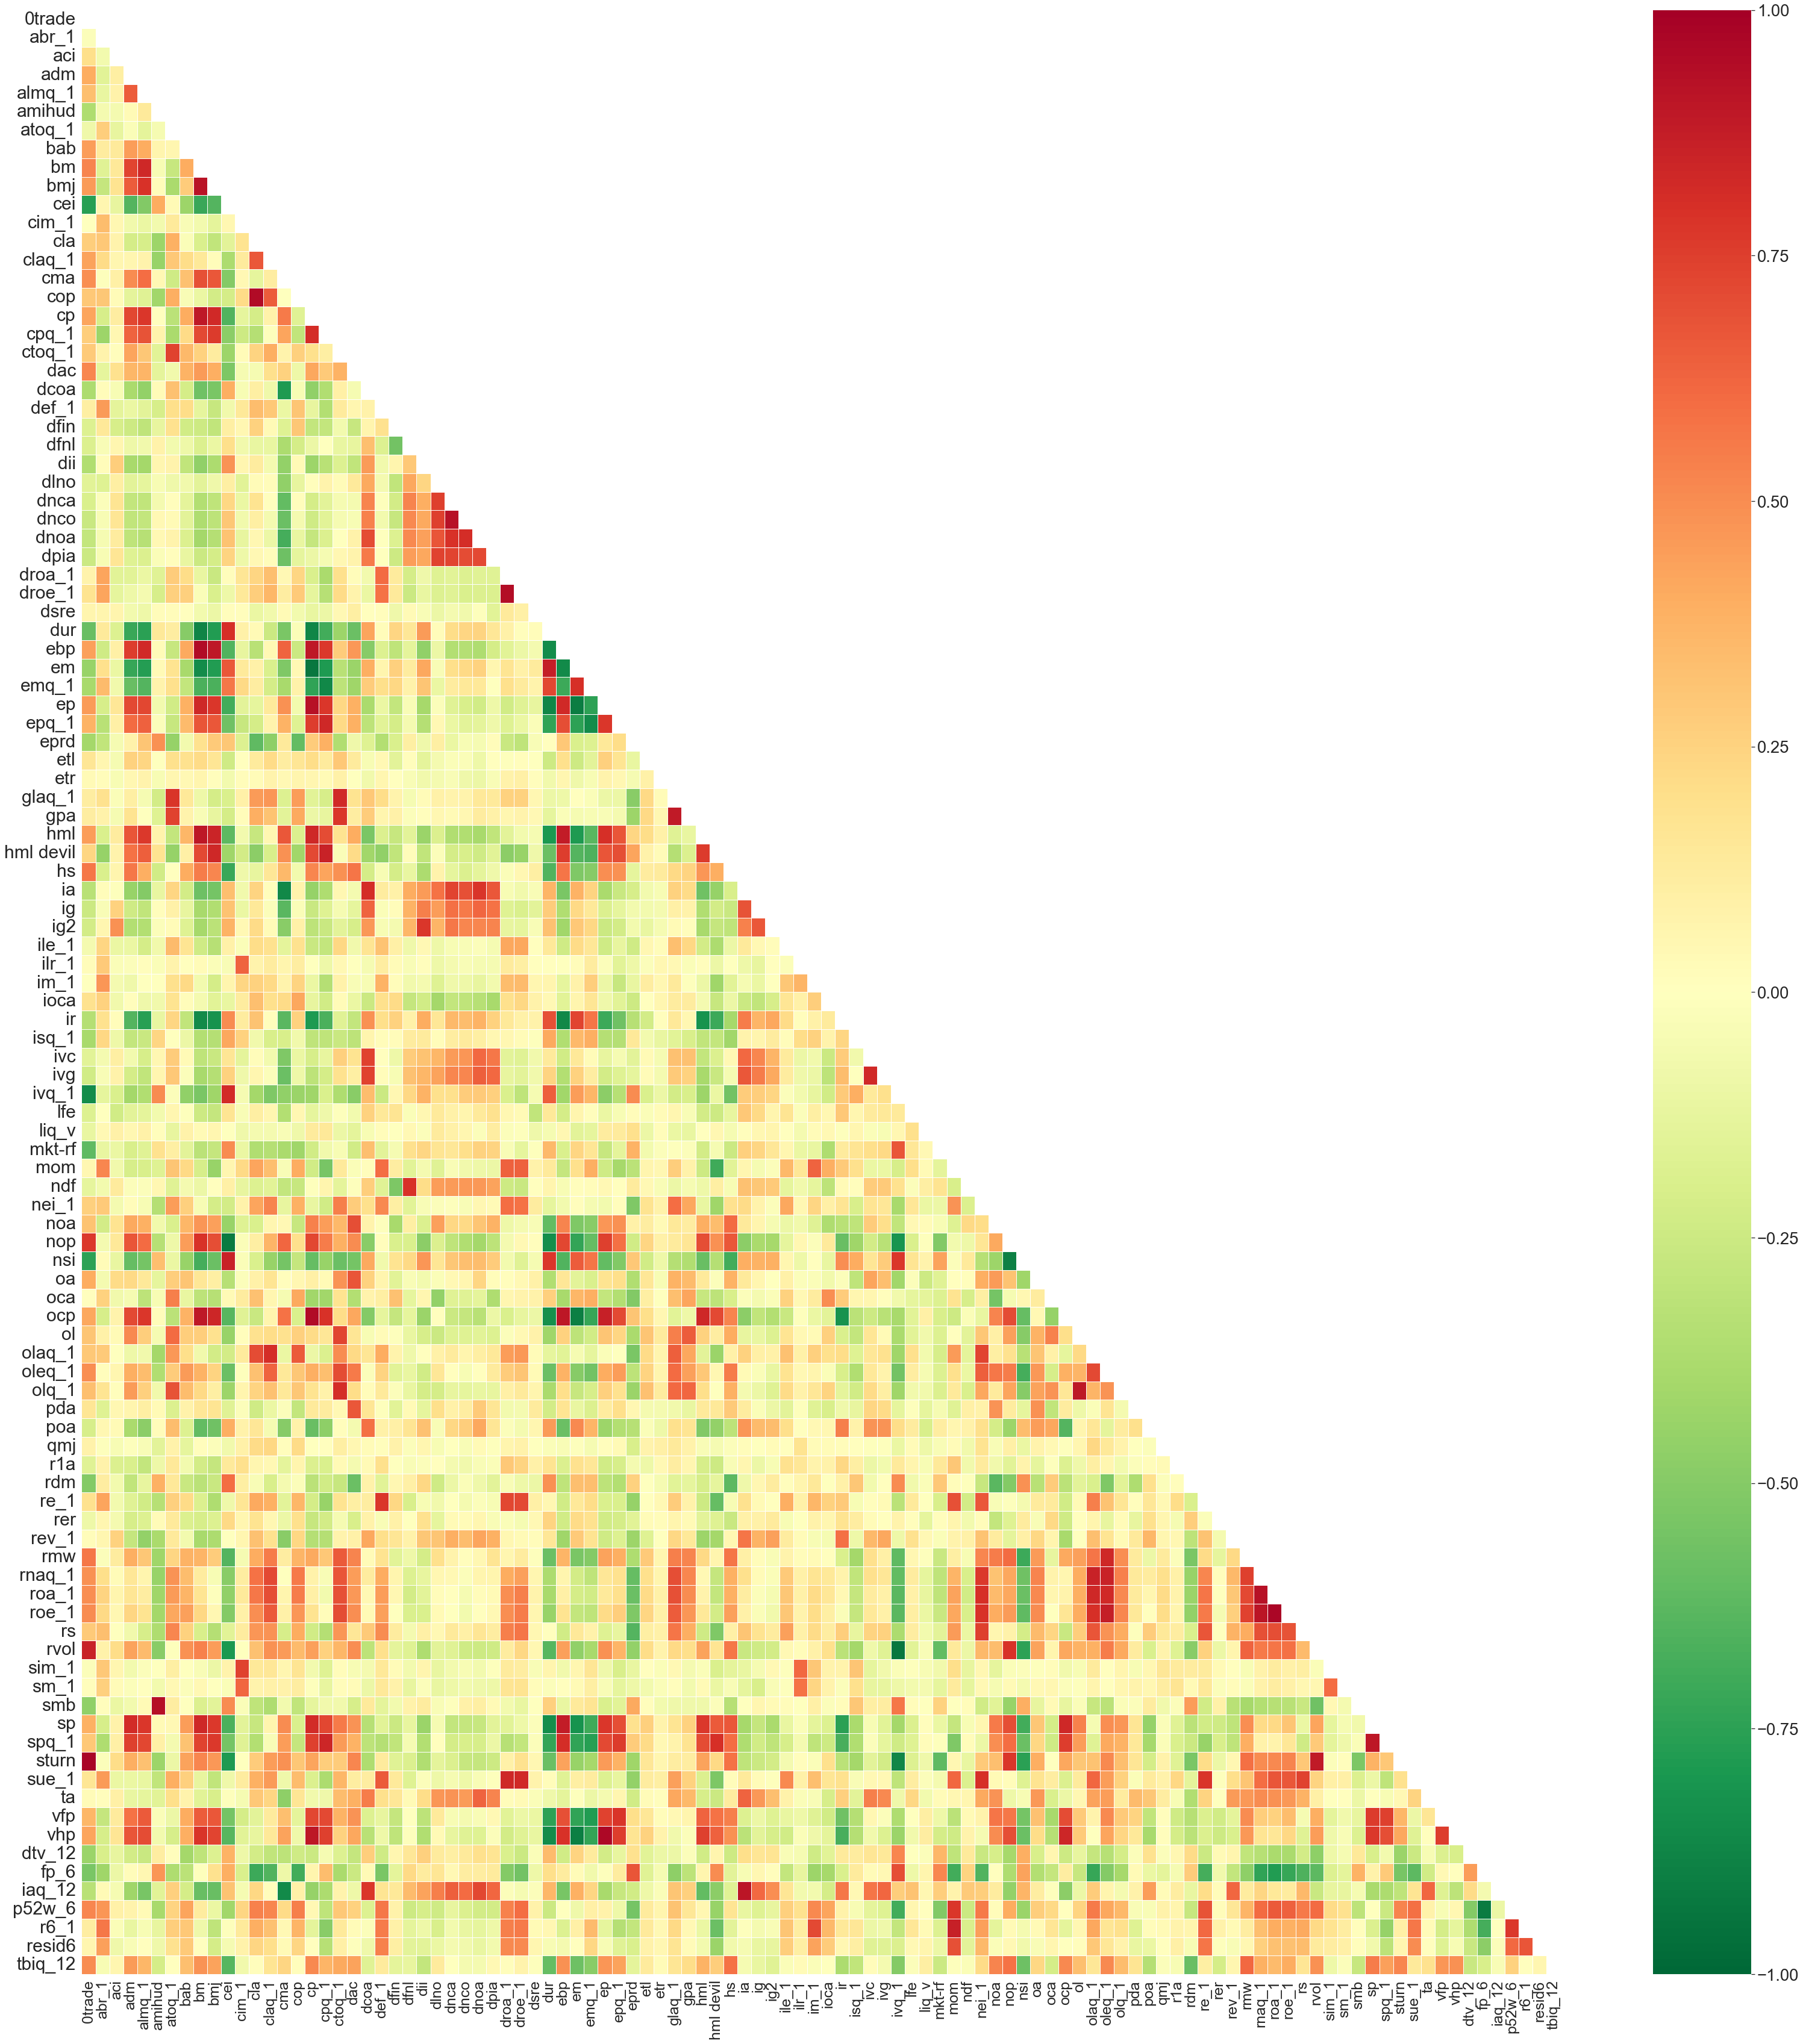

In [67]:
from matplotlib.pyplot import figure

mask = np.zeros_like(factor_correlation)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=2.5)
sns.set_style('whitegrid')
fig = figure(figsize=(55,60))
fig = seaborn.heatmap(factor_correlation, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0,mask = mask,linewidths=0.5,square=False,xticklabels=True, yticklabels=True)
plt.yticks(rotation=0,fontsize= 30)
plt.xticks(rotation=90,fontsize= 25)
plt.autoscale(enable=True,tight=True)
plt.savefig('factor correlations.jpg', dpi=300)
plt.savefig('factor correlations.pdf')
plt.show()

## Testing using ranked matrix

In [24]:
factor_correlation_ranked = monthly_factors.corr(method='spearman')
factor_correlation_ranked.applymap(lambda x: f'{x:.3f}')

,0trade,abr_1,aci,adm,almq_1,amihud,atoq_1,bab,bm,bmj,...,ta,vfp,vhp,dtv_12,fp_6,iaq_12,p52w_6,r6_1,resid6,tbiq_12
0trade,1.000,-0.001,0.167,0.294,0.151,-0.290,-0.176,0.322,0.406,0.367,...,-0.123,0.154,0.327,-0.437,-0.430,-0.340,0.499,0.047,0.073,0.405
abr_1,-0.001,1.000,-0.057,-0.065,-0.086,-0.068,0.223,0.147,-0.122,-0.201,...,0.040,-0.168,-0.123,-0.139,-0.329,0.069,0.377,0.483,0.364,0.033
aci,0.167,-0.057,1.000,0.082,0.004,-0.085,-0.137,0.070,0.072,0.113,...,0.133,0.114,0.130,-0.127,-0.101,0.041,0.081,-0.048,-0.092,0.058
adm,0.294,-0.065,0.082,1.000,0.569,0.061,-0.005,0.320,0.639,0.581,...,-0.235,0.412,0.556,-0.186,0.057,-0.468,0.096,-0.088,-0.015,0.349
almq_1,0.151,-0.086,0.004,0.569,1.000,0.150,-0.168,0.206,0.794,0.774,...,-0.209,0.586,0.653,-0.154,0.174,-0.545,-0.010,-0.089,-0.000,0.253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iaq_12,-0.340,0.069,0.041,-0.468,-0.545,-0.109,0.274,-0.200,-0.644,-0.657,...,0.626,-0.187,-0.347,0.202,-0.153,1.000,-0.080,0.059,-0.052,-0.114
p52w_6,0.499,0.377,0.081,0.096,-0.010,-0.377,0.116,0.297,0.144,-0.023,...,-0.024,-0.091,0.115,-0.383,-0.833,-0.080,1.000,0.674,0.550,0.298
r6_1,0.047,0.483,-0.048,-0.088,-0.089,-0.100,0.214,0.189,-0.072,-0.252,...,-0.016,-0.207,-0.111,-0.166,-0.544,0.059,0.674,1.000,0.608,0.023
resid6,0.073,0.364,-0.092,-0.015,-0.000,-0.071,0.084,0.227,0.026,-0.149,...,-0.100,-0.186,-0.062,-0.118,-0.390,-0.052,0.550,0.608,1.000,0.055


In [25]:
factor_correlation_ranked.describe().applymap(lambda x: f'{x:.3f}')

,0trade,abr_1,aci,adm,almq_1,amihud,atoq_1,bab,bm,bmj,...,ta,vfp,vhp,dtv_12,fp_6,iaq_12,p52w_6,r6_1,resid6,tbiq_12
count,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,...,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000,106.000
mean,0.028,0.068,0.033,0.036,0.009,-0.026,0.103,0.063,0.005,-0.023,...,0.117,0.050,0.043,-0.031,-0.113,0.079,0.092,0.074,0.053,0.069
std,0.316,0.200,0.153,0.342,0.381,0.222,0.276,0.192,0.439,0.429,...,0.277,0.303,0.371,0.214,0.320,0.385,0.303,0.250,0.215,0.256
min,-0.782,-0.340,-0.203,-0.616,-0.727,-0.489,-0.430,-0.322,-0.846,-0.771,...,-0.547,-0.660,-0.848,-0.449,-0.833,-0.864,-0.833,-0.544,-0.390,-0.525
25%,-0.197,-0.056,-0.068,-0.172,-0.218,-0.107,-0.074,-0.095,-0.264,-0.329,...,-0.054,-0.138,-0.185,-0.164,-0.314,-0.113,-0.116,-0.076,-0.086,-0.095
50%,0.023,0.028,0.021,-0.019,-0.066,-0.031,0.087,0.080,-0.058,-0.143,...,0.057,-0.037,-0.031,-0.085,-0.105,0.073,0.086,0.027,0.000,0.064
75%,0.232,0.211,0.103,0.270,0.154,0.041,0.252,0.189,0.204,0.175,...,0.342,0.197,0.229,0.121,0.064,0.307,0.330,0.181,0.151,0.274
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


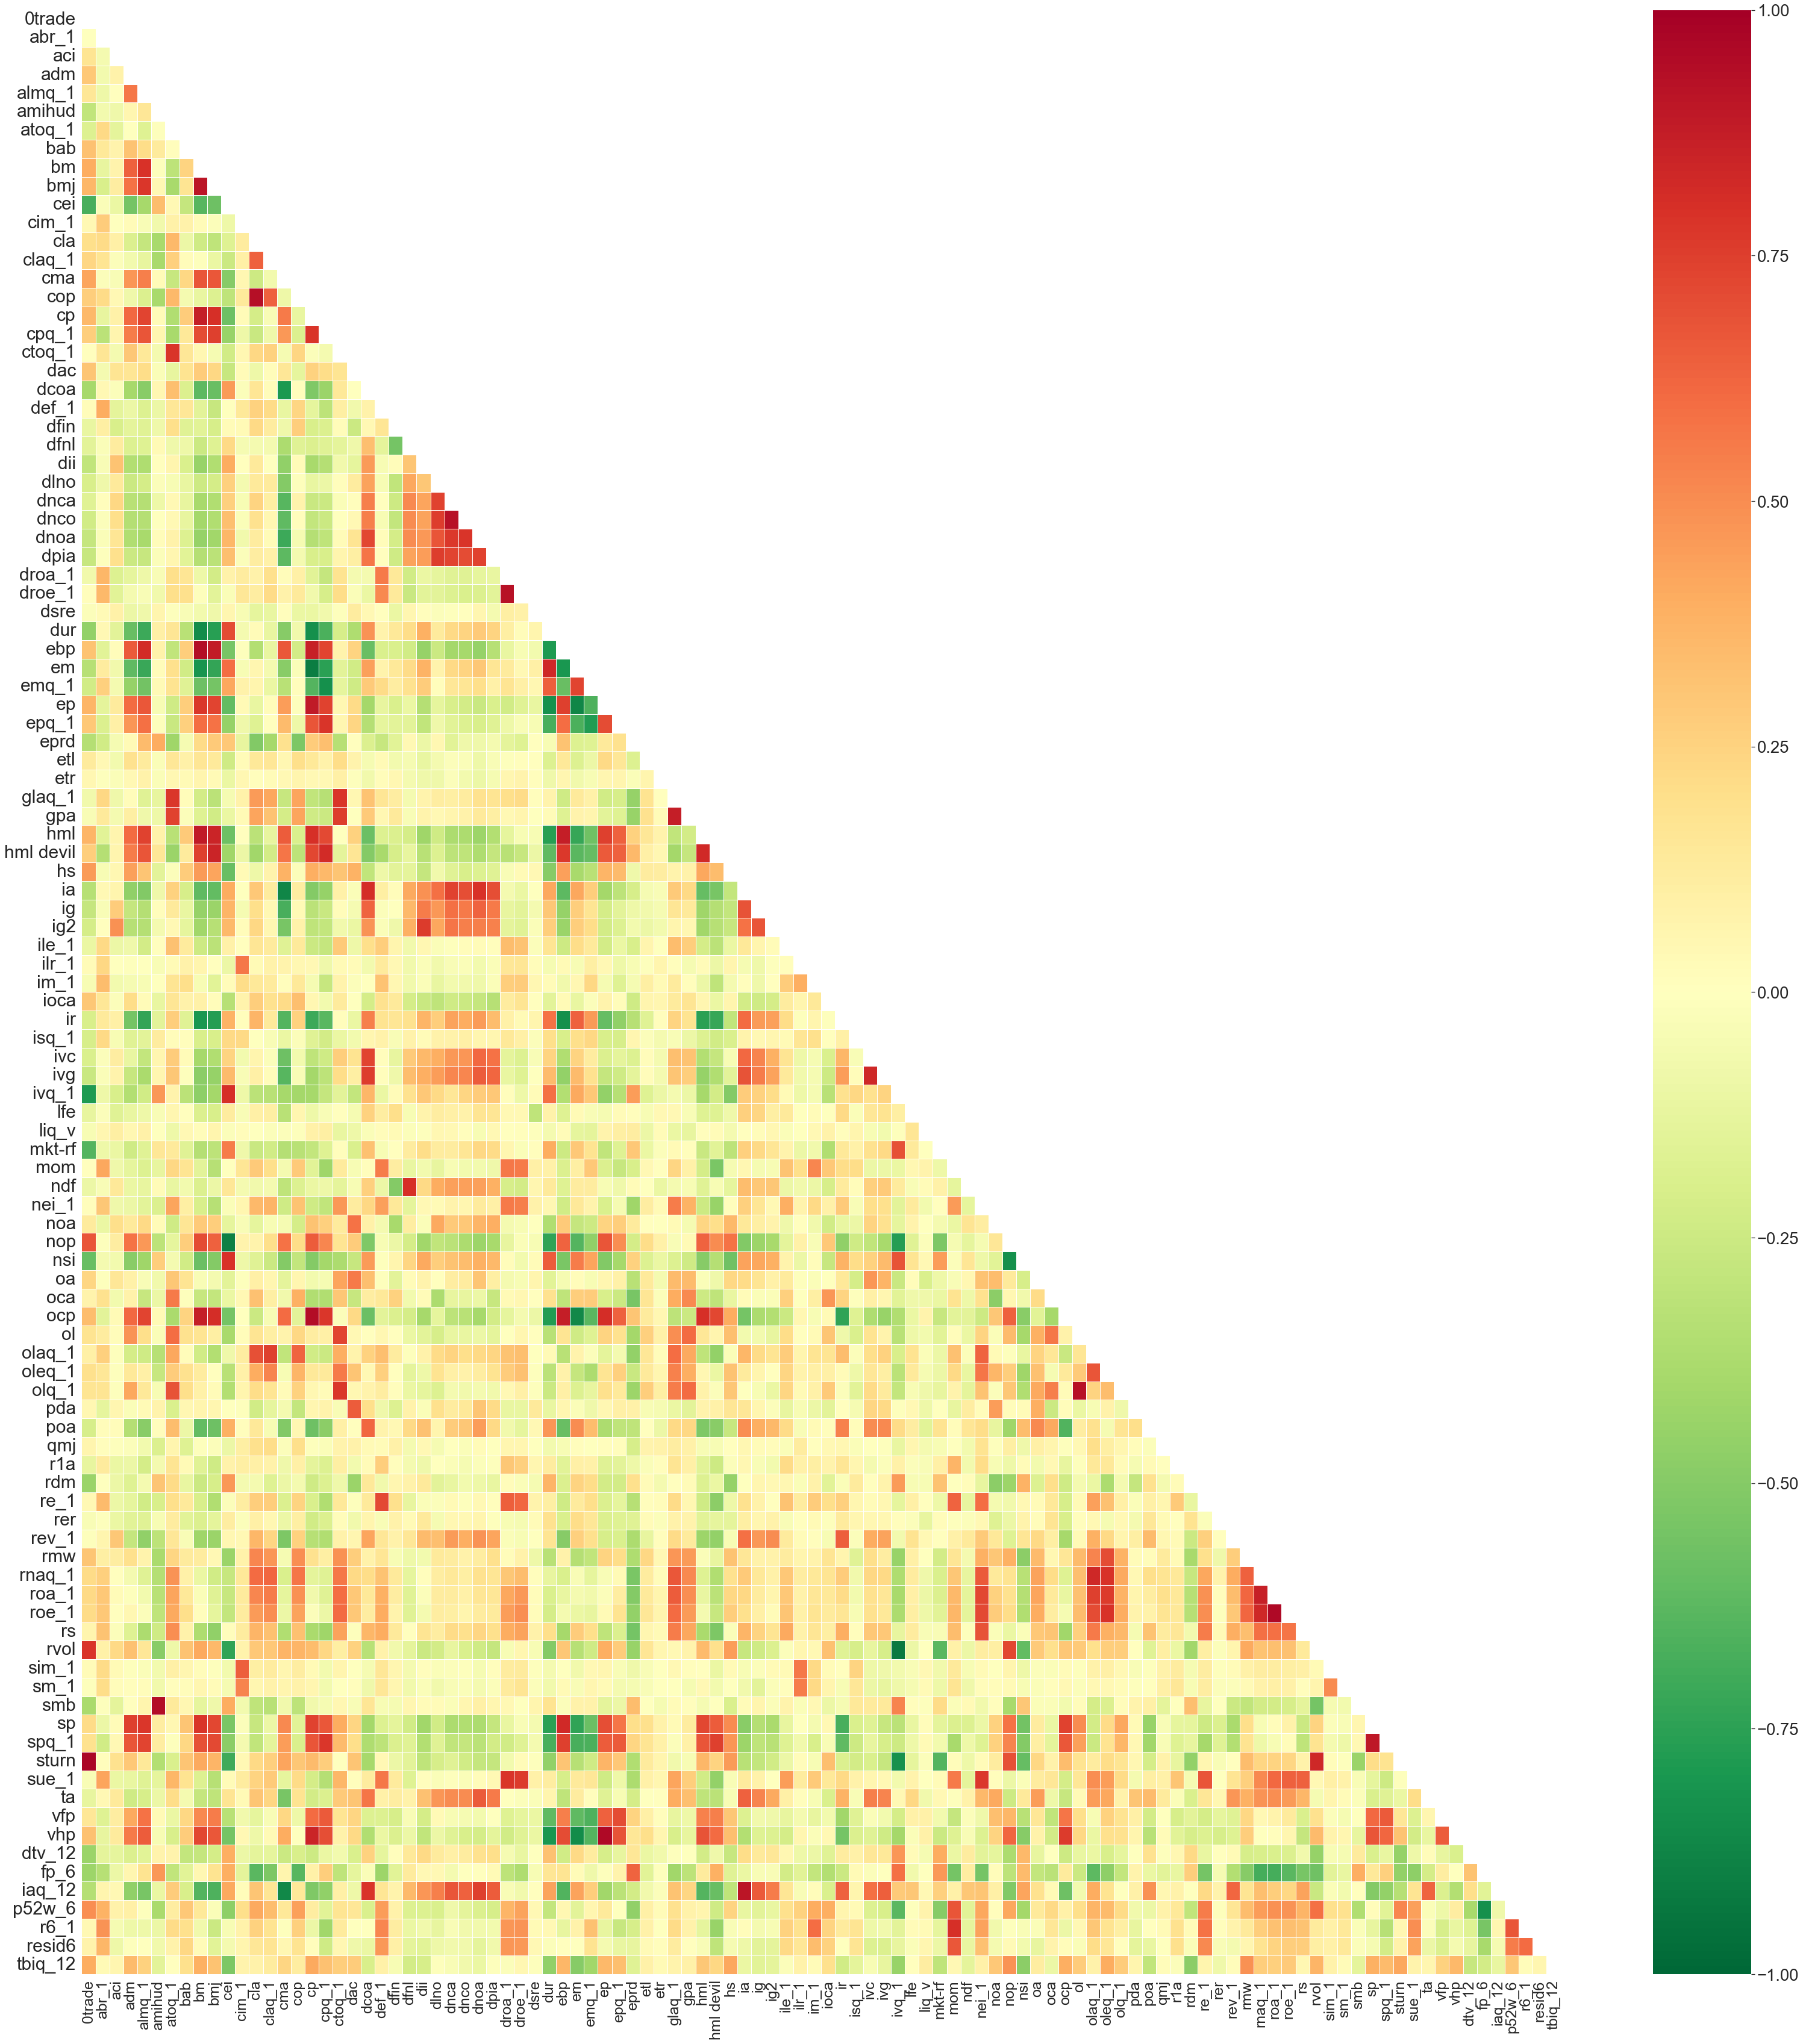

In [68]:
from matplotlib.pyplot import figure

mask = np.zeros_like(factor_correlation_ranked)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=2.5)
sns.set_style('whitegrid')
fig = figure(figsize=(55,60))
fig = seaborn.heatmap(factor_correlation_ranked, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0,mask = mask,linewidths=0.5,square=False,xticklabels=True, yticklabels=True)
plt.yticks(rotation=0,fontsize= 30)
plt.xticks(rotation=90,fontsize= 25)
plt.autoscale(enable=True,tight=True)
plt.savefig('factor correlations ranked.jpg', dpi=300)
plt.savefig('factor correlations ranked.pdf')
plt.show()

In [27]:
from numpy.linalg import matrix_rank
print('the rank of standard method is:  ', matrix_rank(factor_correlation))
print('the rank of ranked   method is:  ', matrix_rank(factor_correlation_ranked))

the rank of standard method is:   106
the rank of ranked   method is:   106


In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    
    #calculating VIF
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return(vif)

vif = (calc_vif(factor_correlation_ranked)).T
vif 


,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
variables,0trade,abr_1,aci,adm,almq_1,amihud,atoq_1,bab,bm,bmj,...,ta,vfp,vhp,dtv_12,fp_6,iaq_12,p52w_6,r6_1,resid6,tbiq_12
VIF,17248.515292,39.703128,51.216864,405.489133,980.592021,3035.084759,1749.279012,70.056458,26557.550713,9009.21658,...,373.599719,341.769842,6780.06287,35.400756,2399.703397,2920.868075,2160.088013,437.10751,91.098971,176.082272


## Removing factors with high correlation 

In [31]:
factors_with_high_corr = sorted(['0trade', 'adm', 'almq_1', 'atoq_1', 'bm', 'bmj', 'cei', 'cei', 'cim_1', 
                                 'cla', 'claq_1', 'cma', 'cop', 'cp', 'cpq_1', 'ctoq_1', 'dac', 'dcoa', 
                                 'dfnl', 'dnca', 'dnco', 'dnoa', 'dpia', 'droa_1', 'droe_1', 'dur', 'ebp', 
                                 'em', 'emq_1', 'epq_1', 'eprd', 'fp_6', 'glaq_1', 'gpa', 'hml', 'hml devil', 
                                 'hs', 'ia', 'iaq_12', 'ig2', 'ir', 'ivc', 'ivg', 'ivq_1', 'mom', 'nei_1', 'noa', 'nop', 
                                 'nsi', 'oa', 'oca', 'ocp', 'olaq_1', 'oleq_1', 'olq_1', 'p52w_6', 'r6_1', 'rdm', 're_1', 
                                 'resid6', 'rmw', 'rnaq_1', 'roa_1', 'rs', 'rvol', 'sim_1', 'smb', 'sp', 'spq_1', 'sturn', 
                                 'sue_1', 'ta', 'vfp', 'vhp', 'vhp'])

factors_with_high_corr_less_base= sorted(['0trade', 'adm', 'almq_1', 'atoq_1', 'bm', 'bmj', 'cei', 
                        'cei', 'cim_1', 'claq_1','cma', 'cop', 'cp', 'cpq_1', 
                        'dac', 'dcoa', 'dfnl', 'dnca', 'dnco', 'dnoa',
                        'dpia', 'droa_1', 'dur', 'ebp', 'em', 'emq_1', 'epq_1',
                        'eprd', 'fp_6', 'glaq_1', 'hml devil', 'hs', 'iaq_12', 
                        'ig2', 'ir', 'ivc', 'ivg', 'ivq_1', 'mom', 'nei_1', 'nop', 'nsi', 
                        'oca', 'ocp', 'olaq_1', 'oleq_1', 'olq_1', 'p52w_6', 'rdm',
                        're_1', 'resid6', 'r6_1','rmw', 'rnaq_1', 'rs', 'rvol', 'sim_1',
                        'spq_1', 'sturn', 'sue_1', 'smb', 'ta', 'vfp', 'vhp', 'vhp'])   #factor list with hml, roa, sp,  cto

factors_with_high_corr_less_base_extended= sorted(['almq_1', 'atoq_1', 'bmj', 'bm','cp','sp','rvol',
                        'cei', 'cim_1', 'claq_1', 'cma','cop', 'cpq_1',  
                        'dac', 'dcoa', 'dfnl', 'dnca', 'dnco', 'dnoa',
                        'dpia', 'droa_1', 'dur', 'ebp', 'em', 'emq_1', 'epq_1',
                        'eprd', 'glaq_1', 'hs', 'iaq_12','ig2', 'ir', 'ivc', 
                        'ivg', 'ivq_1', 'nei_1', 'nop',  'ocp', 'olaq_1', 'oleq_1',
                        'olq_1', 'p52w_6', 're_1','rmw', 'rnaq_1',  'spq_1', 
                        'sturn', 'smb', 'ta', 'vfp', 'vhp', 'vhp'])   #factor list with hml, roa, sp,  cto



monthly_factors_adjusted = monthly_factors.drop(columns=factors_with_high_corr).copy()

monthly_factors_base = monthly_factors.drop(columns=factors_with_high_corr_less_base).copy()

monthly_factors_base_extended = monthly_factors.drop(columns=factors_with_high_corr_less_base_extended).copy()


# ##########################################################  saving  ###################
# monthly_factors_adjusted.to_csv('monthly_factors_adjusted.csv')
# file_saver('monthly_factors_adjusted.csv','monthly_factors_adjusted.csv')
# #########################################################################################

# ##########################################################  saving  ###################
# monthly_factors_base.to_csv('monthly_factors_base.csv')
# file_saver('monthly_factors_base.csv','monthly_factors_base.csv')
# #########################################################################################

# ##########################################################  saving  ###################
# monthly_factors_base_extended.to_csv('monthly_factors_base_extended.csv')
# file_saver('monthly_factors_base_extended.csv','monthly_factors_base_extended.csv')
# #########################################################################################

In [49]:
monthly_factors_adj = pd.read_csv(path_bucket+'monthly_factors_adjusted.csv')
monthly_factors_adj = monthly_factors_adj.set_index('date',drop=True)
monthly_factors_adj = monthly_factors_adj.applymap(lambda x: f'{x:.3f}')
monthly_factors_adj = monthly_factors_adj.astype('float')
monthly_factors_adj= monthly_factors_adj.loc[(monthly_factors_adj.index>=('1977-01'))&(monthly_factors_adj.index<=('2020-12'))]

monthly_factors_adj.head()

,abr_1,aci,amihud,bab,def_1,dfin,dii,dlno,dsre,ep,...,pda,poa,qmj,r1a,rer,rev_1,roe_1,sm_1,dtv_12,tbiq_12
date,,,,,,,,,,,,,,,,,,,,,
1977-07,-0.005,-0.021,0.013,0.029,0.026,0.007,-0.016,0.002,-0.004,0.001,...,-0.005,0.005,-0.008,0.013,0.012,-0.016,0.018,-0.012,-0.011,0.015
1977-08,0.017,-0.004,0.001,0.003,0.004,0.020,0.001,0.001,-0.008,-0.035,...,-0.002,0.010,0.009,0.021,-0.007,-0.023,0.018,0.004,-0.066,-0.003
1977-09,0.018,-0.003,0.012,0.004,0.057,0.000,0.000,0.013,-0.007,0.014,...,0.011,0.007,0.031,0.008,0.002,-0.014,0.023,-0.011,-0.071,0.013
1977-10,-0.007,-0.006,0.017,0.002,0.009,0.007,0.003,-0.005,-0.004,0.015,...,-0.000,0.010,0.004,0.013,0.019,0.008,-0.013,-0.010,0.055,0.008
1977-11,0.032,-0.010,0.041,0.003,0.021,0.017,-0.003,-0.019,-0.007,-0.000,...,-0.010,-0.009,0.011,0.019,-0.014,-0.034,0.042,0.017,-0.005,0.001


In [50]:
monthly_factors_base = pd.read_csv(path_bucket+'monthly_factors_base.csv')
monthly_factors_base = monthly_factors_base.set_index('date',drop=True)
monthly_factors_base = monthly_factors_base.applymap(lambda x: f'{x:.3f}')
monthly_factors_base = monthly_factors_base.astype('float')
monthly_factors_base= monthly_factors_base.loc[(monthly_factors_base.index>=('1977-01'))&(monthly_factors_base.index<=('2020-12'))]

monthly_factors_base.head()

,abr_1,aci,amihud,bab,cla,ctoq_1,def_1,dfin,dii,dlno,...,qmj,r1a,rer,rev_1,roa_1,roe_1,sm_1,sp,dtv_12,tbiq_12
date,,,,,,,,,,,,,,,,,,,,,
1977-07,-0.005,-0.021,0.013,0.029,0.024,0.003,0.026,0.007,-0.016,0.002,...,-0.008,0.013,0.012,-0.016,0.012,0.018,-0.012,-0.005,-0.011,0.015
1977-08,0.017,-0.004,0.001,0.003,0.022,0.017,0.004,0.020,0.001,0.001,...,0.009,0.021,-0.007,-0.023,0.022,0.018,0.004,-0.027,-0.066,-0.003
1977-09,0.018,-0.003,0.012,0.004,0.022,-0.007,0.057,0.000,0.000,0.013,...,0.031,0.008,0.002,-0.014,0.013,0.023,-0.011,-0.007,-0.071,0.013
1977-10,-0.007,-0.006,0.017,0.002,0.003,-0.003,0.009,0.007,0.003,-0.005,...,0.004,0.013,0.019,0.008,-0.007,-0.013,-0.010,0.006,0.055,0.008
1977-11,0.032,-0.010,0.041,0.003,0.007,0.018,0.021,0.017,-0.003,-0.019,...,0.011,0.019,-0.014,-0.034,0.035,0.042,0.017,0.012,-0.005,0.001


In [51]:
monthly_factors_base_extended = pd.read_csv(path_bucket+'monthly_factors_base_extended.csv')
monthly_factors_base_extended = monthly_factors_base_extended.set_index('date',drop=True)
monthly_factors_base_extended = monthly_factors_base_extended.applymap(lambda x: f'{x:.3f}')
monthly_factors_base_extended = monthly_factors_base_extended.astype('float')
monthly_factors_base_extended= monthly_factors_base_extended.loc[(monthly_factors_base_extended.index>=('1977-01'))&(monthly_factors_base_extended.index<=('2020-12'))]

monthly_factors_base_extended.head()

,0trade,abr_1,aci,adm,amihud,bab,cla,ctoq_1,def_1,dfin,...,roe_1,rs,sim_1,sm_1,sue_1,dtv_12,fp_6,r6_1,resid6,tbiq_12
date,,,,,,,,,,,,,,,,,,,,,
1977-07,0.019,-0.005,-0.021,0.013,0.013,0.029,0.024,0.003,0.026,0.007,...,0.018,0.022,0.024,-0.012,0.025,-0.011,-0.009,-0.016,0.001,0.015
1977-08,-0.006,0.017,-0.004,-0.004,0.001,0.003,0.022,0.017,0.004,0.020,...,0.018,0.031,0.024,0.004,0.015,-0.066,-0.025,-0.012,-0.017,-0.003
1977-09,0.010,0.018,-0.003,-0.008,0.012,0.004,0.022,-0.007,0.057,0.000,...,0.023,0.018,-0.000,-0.011,0.021,-0.071,-0.022,0.025,0.007,0.013
1977-10,0.011,-0.007,-0.006,0.012,0.017,0.002,0.003,-0.003,0.009,0.007,...,-0.013,0.001,-0.012,-0.010,0.001,0.055,-0.008,-0.007,0.003,0.008
1977-11,-0.031,0.032,-0.010,0.001,0.041,0.003,0.007,0.018,0.021,0.017,...,0.042,0.034,0.006,0.017,0.044,-0.005,0.013,0.026,0.007,0.001


## Final look at factor correlations

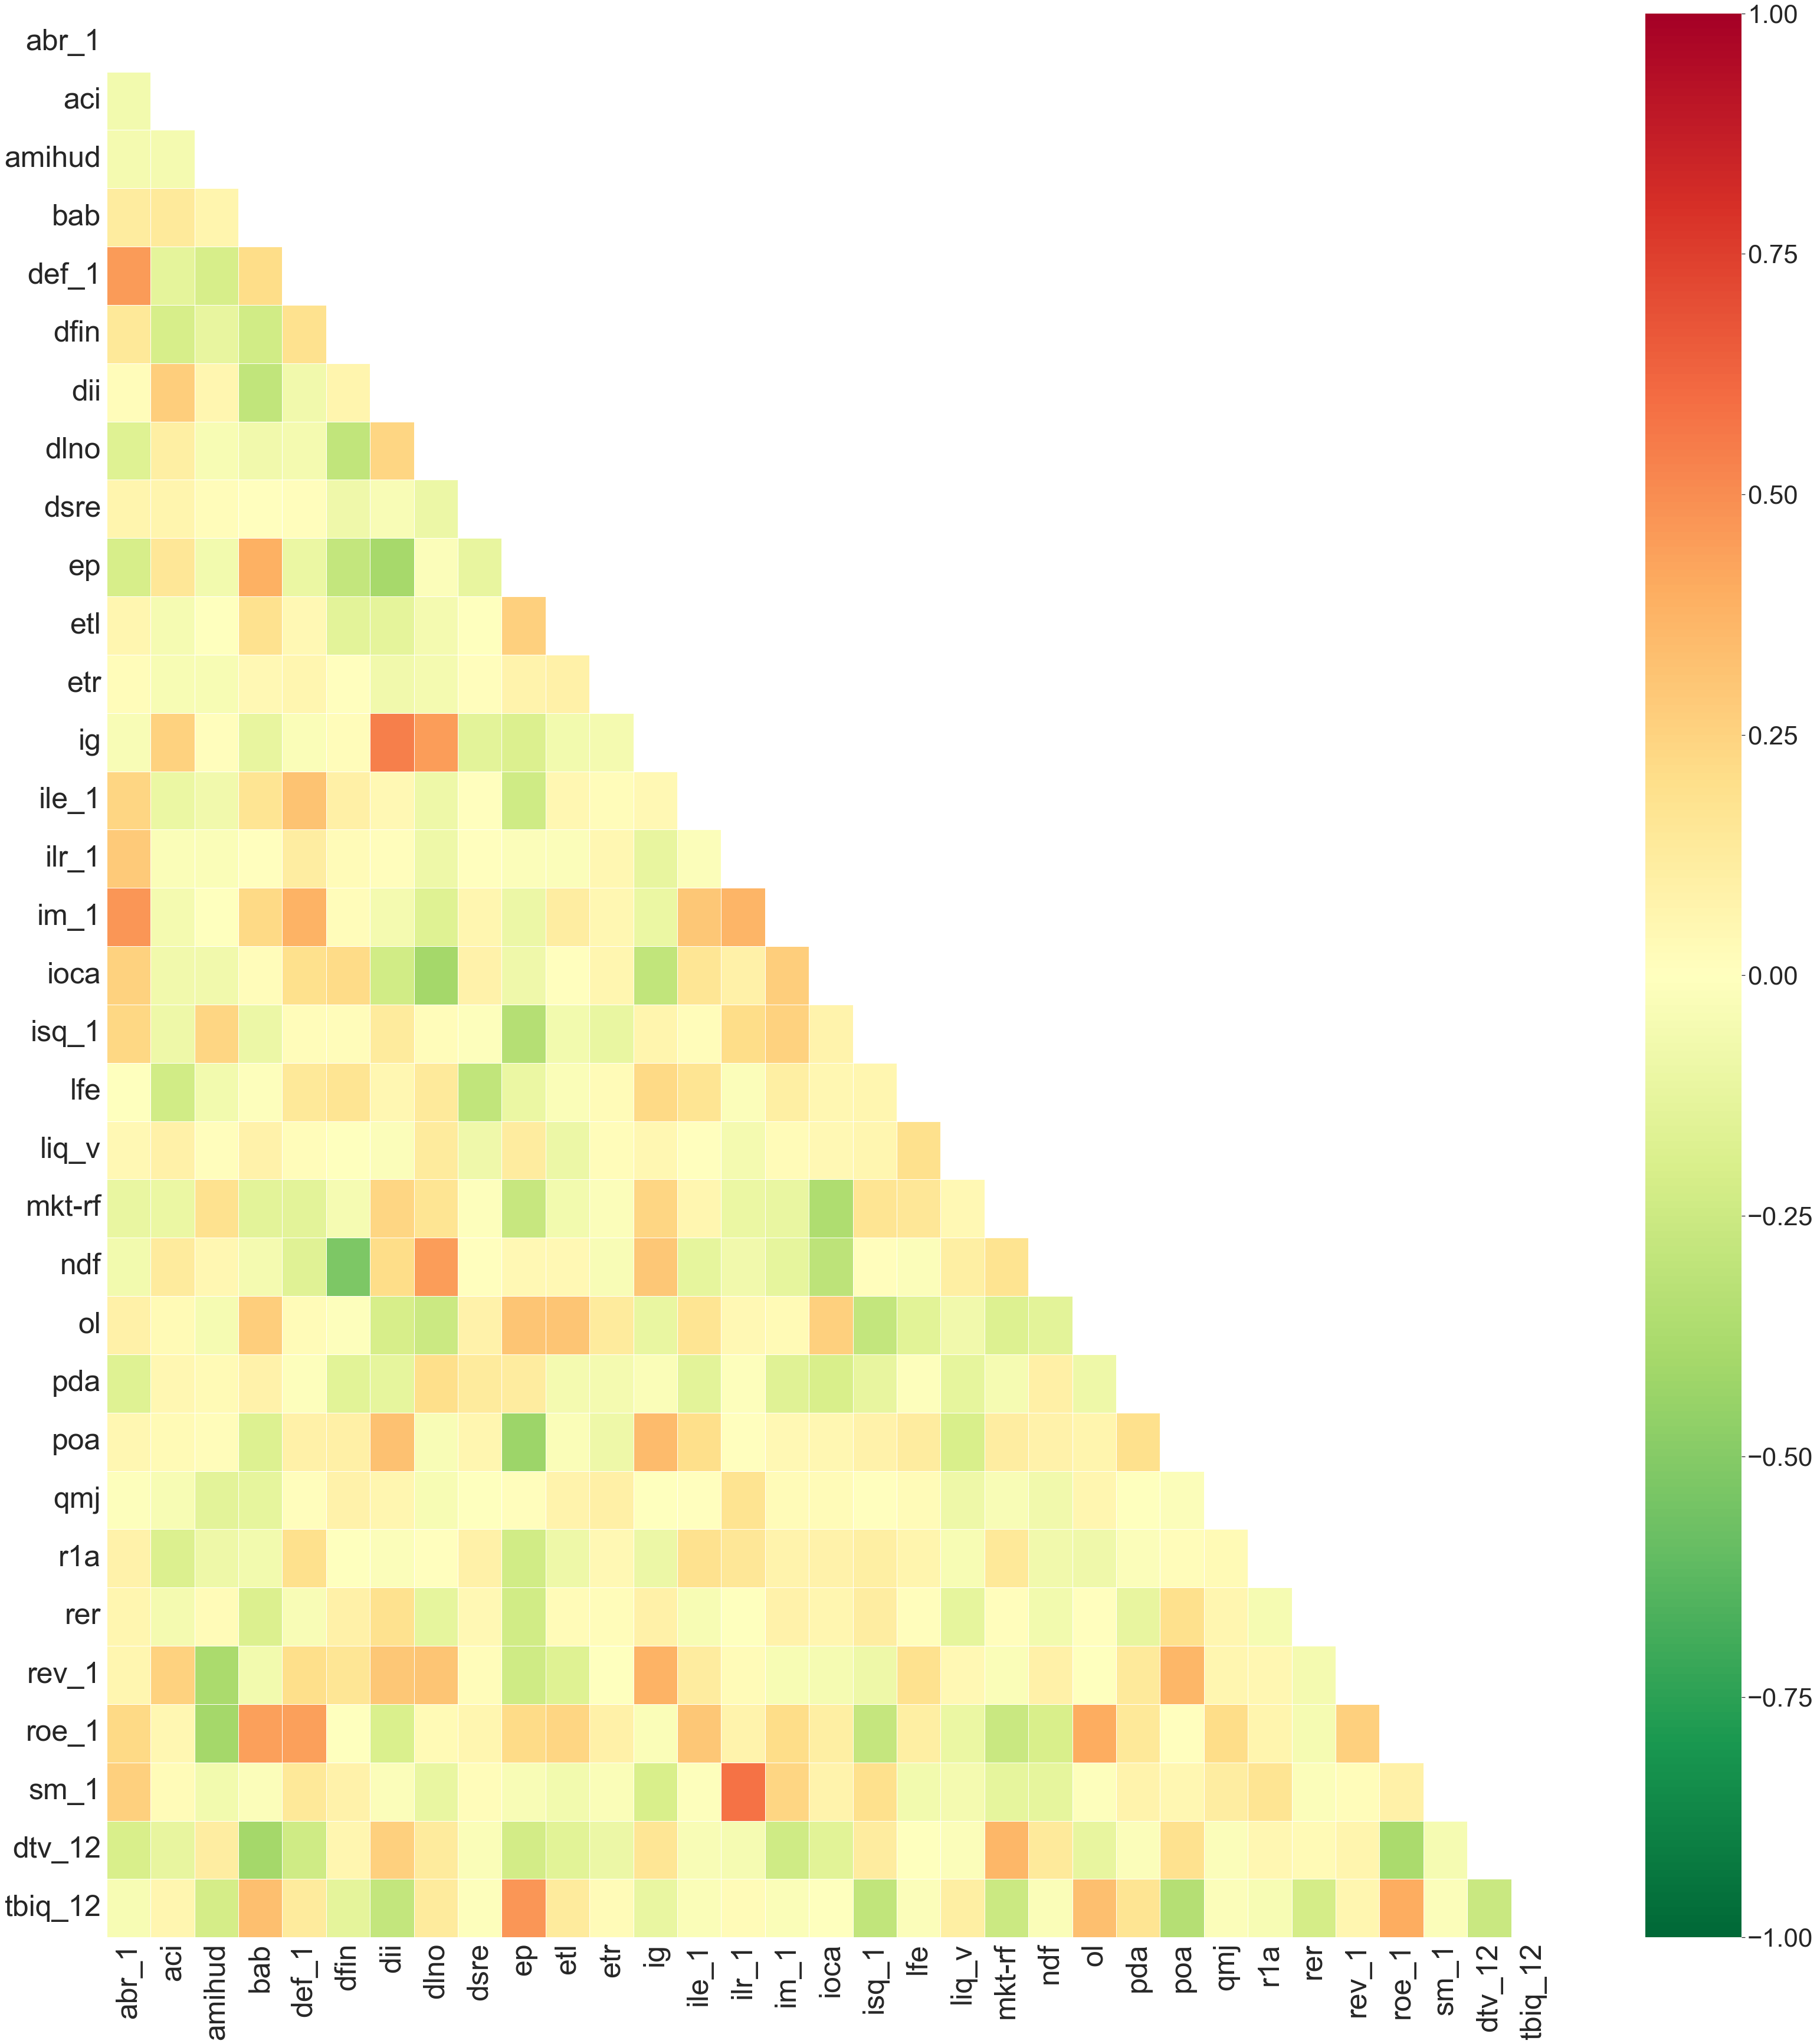

In [59]:
factor_correlation = monthly_factors_adjusted.corr(method='pearson')

from matplotlib.pyplot import figure

mask = np.zeros_like(factor_correlation)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=4)
sns.set_style('whitegrid')
fig= figure(figsize=(55,60))
ax = seaborn.heatmap(factor_correlation, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0,mask = mask,linewidths=0.5,square=False,xticklabels=True, yticklabels=True)
plt.yticks(rotation=0,fontsize= 50)
plt.xticks(rotation=90,fontsize= 50)
plt.autoscale(enable=True,tight=True)

plt.savefig('factor correlations_adjusted.jpg', dpi=300)
plt.savefig('factor correlations_adjusted.pdf')
plt.show()

In [37]:
pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_colwidth', 30)  # or 199

factor_correlation = monthly_factors_adjusted.corr(method='pearson')
factor_correlation.applymap(lambda x: f'{x:.3f}')

vif = (calc_vif(factor_correlation)).T
vif 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
variables,abr_1,aci,amihud,bab,def_1,dfin,dii,dlno,dsre,ep,etl,etr,ig,ile_1,ilr_1,im_1,ioca,isq_1,lfe,liq_v,mkt-rf,ndf,ol,pda,poa,qmj,r1a,rer,rev_1,roe_1,sm_1,dtv_12,tbiq_12
VIF,9.041751,6.826917,7.108835,12.642615,9.681394,11.915005,12.815428,15.697559,2.307772,26.353266,3.118115,1.457188,18.537256,5.136827,8.226967,9.071323,9.133943,5.682134,5.134712,2.644744,7.025517,11.931538,15.040734,5.770285,16.352793,2.547158,2.71024,2.478616,14.055558,39.79596,7.562933,6.458748,10.413997


In [40]:
vif.iloc[1,:].mean()

9.838722109430224

# Cross-sectional prediction: Linear Ordinary Least Sqaures & Regularized linear Regressions 

## Regression inputs

In [54]:
##################################################################### Config    ##############################################################
window =  252*3
n_factors = 33    #base extended 55     #base=43     adjusted=33
n_factors_pca = 10
factor_returns = monthly_factors_adj.copy(deep=True)
start_date = ('1977-07')
end_date = ('2020-12')
Y_name = 'fwd_quintile' #fwd_weekly_exret

##############################################################################################################################################

In [55]:
monthly_stock_data_wins_quin= pd.read_csv(wrds_data_file_wins_quin)
monthly_stock_data_wins_quin= monthly_stock_data_wins_quin.loc[(monthly_stock_data_wins_quin.date>=start_date)&(monthly_stock_data_wins_quin.date<=end_date)]
monthly_stock_data_wins_quin = monthly_stock_data_wins_quin.drop(columns=['Unnamed: 0'])
monthly_stock_data_wins_quin = monthly_stock_data_wins_quin.set_index('date')

sp_data_wins_quin = pd.read_csv(path_bucket + 'sp_data_wins_quin.csv')
sp_data_wins_quin= sp_data_wins_quin.loc[(sp_data_wins_quin.date>=start_date)&(sp_data_wins_quin.date<=end_date)]
sp_data_wins_quin = sp_data_wins_quin.drop(columns=['Unnamed: 0'])
sp_data_wins_quin = sp_data_wins_quin.set_index('date')


large_cap_filter = monthly_stock_data_wins_quin.loc[monthly_stock_data_wins_quin.index==('2020-10')]
print('number of current components: ', len(large_cap_filter.permno.unique()))
print('number of small-mid caps: ', len(large_cap_filter.loc[large_cap_filter.vweights<=0.001].permno.unique()))
print('number of large caps: ',  len(large_cap_filter.loc[large_cap_filter.vweights>0.001].permno.unique()))

monthly_stock_data_wins_quin = monthly_stock_data_wins_quin.loc[monthly_stock_data_wins_quin.permno.isin(large_cap_filter.permno.unique())]
monthly_stock_data_large_cap = monthly_stock_data_wins_quin.loc[monthly_stock_data_wins_quin.permno.isin(large_cap_filter.loc[large_cap_filter.vweights>0.001].permno.unique())]
monthly_stock_data_sm_md_cap = monthly_stock_data_wins_quin.loc[monthly_stock_data_wins_quin.permno.isin(large_cap_filter.loc[large_cap_filter.vweights<0.001].permno.unique())]

monthly_stock_data_wins_quin.dropna(inplace=True) 
monthly_stock_data_wins_quin.head(5)

number of current components:  3344
number of small-mid caps:  3152
number of large caps:  192


,permno,prc,ret,shrout,mktcap,vweights,ret_mk,monthly_exret,fwd_monthly_exret,quintile,fwd_quintile
date,,,,,,,,,,,
1986-03,10026.0,21.25,0.133333,1945.0,41331.25,0.000021,0.059830,0.073504,0.073118,3,4
1986-04,10026.0,22.75,0.070588,1945.0,44248.75,0.000028,-0.002530,0.073118,0.353330,4,4
1986-05,10026.0,32.00,0.406593,1945.0,62240.00,0.000023,0.053263,0.353330,-0.176722,4,3
1986-06,10026.0,18.00,-0.156250,2918.0,52524.00,0.000015,0.020472,-0.176722,-0.325413,3,3
1986-07,10026.0,11.25,-0.335632,2918.0,32827.50,0.000013,-0.049587,-0.325413,-0.140751,3,2


In [56]:
# ################################################# saving ###################################################
monthly_stock_data_wins_quin.to_csv('monthly_stock_data_final.csv')
file_saver('monthly_stock_data_final.csv','monthly_stock_data_final.csv')

monthly_stock_data_large_cap.to_csv('monthly_stock_data_large_cap.csv')
file_saver('monthly_stock_data_large_cap.csv','monthly_stock_data_large_cap.csv')

monthly_stock_data_sm_md_cap.to_csv('monthly_stock_data_sm_md_cap.csv')
file_saver('monthly_stock_data_sm_md_cap.csv','monthly_stock_data_sm_md_cap.csv')
# ##############################################################################################################

In [57]:
regression_df =  monthly_stock_data_wins_quin.groupby('permno').apply(lambda x: pd.concat([x[Y_name], factor_returns.loc[factor_returns.index.isin(x.index)]],axis=1))
regression_df.reset_index(inplace=True)
regression_df = regression_df.dropna()
regression_df.head()

,permno,date,fwd_quintile,abr_1,aci,amihud,bab,def_1,dfin,dii,dlno,dsre,ep,etl,etr,ig,ile_1,ilr_1,im_1,ioca,isq_1,lfe,liq_v,mkt-rf,ndf,ol,pda,poa,qmj,r1a,rer,rev_1,roe_1,sm_1,dtv_12,tbiq_12
0,10026.0,1986-03,4,0.002,0.014,-0.006,0.045,0.011,0.012,0.002,-0.025,0.011,0.022,-0.023,0.010,0.001,0.008,0.030,0.021,0.009,-0.009,-0.010,0.036,0.049,-0.015,0.050,-0.009,0.008,0.015,0.012,-0.009,0.032,0.022,0.063,-0.011,0.002
1,10026.0,1986-04,4,0.004,-0.011,0.032,0.019,0.027,0.009,-0.004,0.010,0.015,-0.034,-0.002,-0.002,-0.004,0.000,-0.036,0.008,-0.006,-0.015,-0.004,-0.005,-0.013,0.005,-0.009,0.017,0.026,0.009,-0.009,0.004,0.020,0.025,0.010,-0.002,0.006
2,10026.0,1986-05,3,0.007,0.008,-0.011,0.033,0.014,0.008,0.003,-0.014,0.001,-0.012,-0.006,0.009,-0.013,0.028,-0.018,-0.016,0.017,0.003,-0.012,0.027,0.046,-0.018,0.041,-0.005,-0.005,0.020,0.030,-0.008,0.024,0.041,0.008,0.064,0.028
3,10026.0,1986-06,3,0.019,-0.007,-0.006,0.051,0.063,0.015,-0.013,-0.017,-0.003,0.025,0.019,0.006,-0.035,0.014,0.043,0.030,0.030,0.017,0.004,0.060,0.010,0.002,0.024,-0.008,-0.004,0.008,0.037,0.008,0.074,0.060,0.033,-0.002,0.021
4,10026.0,1986-07,2,0.009,-0.004,-0.020,0.014,0.049,0.004,-0.015,-0.013,-0.008,0.063,0.004,0.010,-0.005,-0.028,-0.012,-0.031,0.025,-0.003,0.003,-0.018,-0.065,-0.000,0.012,0.009,-0.012,0.022,-0.030,-0.010,0.050,0.037,0.037,-0.005,0.005


In [58]:
regression_df.groupby('permno').apply(lambda x: len(x.permno)).min()

149

In [59]:
sp_regression_df =  sp_data_wins_quin.groupby('permno').apply(lambda x: pd.concat([x[Y_name], factor_returns.loc[factor_returns.index.isin(x.index)]],axis=1))
sp_regression_df.reset_index(inplace=True)
sp_regression_df = sp_regression_df.dropna()
sp_regression_df.dropna(inplace=True)
sp_regression_df.head()

,permno,date,fwd_quintile,abr_1,aci,amihud,bab,def_1,dfin,dii,dlno,dsre,ep,etl,etr,ig,ile_1,ilr_1,im_1,ioca,isq_1,lfe,liq_v,mkt-rf,ndf,ol,pda,poa,qmj,r1a,rer,rev_1,roe_1,sm_1,dtv_12,tbiq_12
0,10104.0,1986-04,2,0.004,-0.011,0.032,0.019,0.027,0.009,-0.004,0.010,0.015,-0.034,-0.002,-0.002,-0.004,0.000,-0.036,0.008,-0.006,-0.015,-0.004,-0.005,-0.013,0.005,-0.009,0.017,0.026,0.009,-0.009,0.004,0.020,0.025,0.010,-0.002,0.006
1,10104.0,1986-05,2,0.007,0.008,-0.011,0.033,0.014,0.008,0.003,-0.014,0.001,-0.012,-0.006,0.009,-0.013,0.028,-0.018,-0.016,0.017,0.003,-0.012,0.027,0.046,-0.018,0.041,-0.005,-0.005,0.020,0.030,-0.008,0.024,0.041,0.008,0.064,0.028
2,10104.0,1986-06,1,0.019,-0.007,-0.006,0.051,0.063,0.015,-0.013,-0.017,-0.003,0.025,0.019,0.006,-0.035,0.014,0.043,0.030,0.030,0.017,0.004,0.060,0.010,0.002,0.024,-0.008,-0.004,0.008,0.037,0.008,0.074,0.060,0.033,-0.002,0.021
3,10104.0,1986-07,1,0.009,-0.004,-0.020,0.014,0.049,0.004,-0.015,-0.013,-0.008,0.063,0.004,0.010,-0.005,-0.028,-0.012,-0.031,0.025,-0.003,0.003,-0.018,-0.065,-0.000,0.012,0.009,-0.012,0.022,-0.030,-0.010,0.050,0.037,0.037,-0.005,0.005
4,10104.0,1986-08,1,-0.001,-0.014,-0.052,-0.016,-0.017,0.012,0.004,-0.013,-0.027,0.014,0.009,-0.001,-0.020,-0.019,0.005,-0.054,-0.014,-0.006,0.007,-0.027,0.061,-0.019,-0.028,-0.003,-0.042,0.016,0.000,0.003,-0.048,-0.034,0.009,-0.007,0.000


In [60]:
grid_search_permno = regression_df.permno.unique()[:500]
Grid_search_df = regression_df.loc[regression_df.permno.isin(grid_search_permno)].copy()
Grid_search_df.dropna(inplace=True)

In [61]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

def Grid_search_function(df, Y_name, regmodel):
    
    train_split =int(len(df)*0.6) 
    df = df.iloc[:train_split,:]
    X = df.iloc[:,3:]
    Y = df.loc[:,Y_name]
    alpha = [1e-7, 1e-6, 1e-5, 2.5e-5, 1e-4,2.5e-4, 1e-3,2.5e-3, 1e-2,2.5e-2, 1e-1]
    l1_ratio = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    params = {'alpha':alpha}
    params_en = {'alpha':alpha, 'l1_ratio':l1_ratio}
    if regmodel=='Ridge':
        ridge_model = Ridge()
        grid_search_ridge = GridSearchCV(ridge_model, params,cv=15)
        grid_search_ridge.fit(X,Y)
        best_params_ridge = grid_search_ridge.best_params_
        return best_params_ridge
    if regmodel=='Lasso':
        lasso_model = Lasso()
        grid_search_lasso = GridSearchCV(lasso_model, params,cv=15)
        grid_search_lasso.fit(X,Y)
        best_params_lasso = grid_search_lasso.best_params_
        return best_params_lasso
    if regmodel=='EN':
        EN_model = ElasticNet()
        grid_search_en = GridSearchCV(EN_model, params,cv=15)
        grid_search_en.fit(X,Y)
        best_params_en = grid_search_en.best_params_
        return best_params_en

In [62]:
alpha_lasso = Grid_search_function(Grid_search_df, Y_name,'Lasso')
alpha_lasso = alpha_lasso['alpha'] 
alpha_ridge = Grid_search_function(Grid_search_df,Y_name, 'Lasso')
alpha_ridge = alpha_ridge['alpha']

params_en = Grid_search_function(Grid_search_df,Y_name, 'EN')
params_en

{'alpha': 1e-05}

In [63]:
alpha_lasso #1e-08

1e-05

In [64]:
alpha_ridge #1e-08

1e-05

In [65]:
params_en

{'alpha': 1e-05}

In [66]:
# alpha_lasso,  alpha_ridge, alpha_en, l1_en = 1e-05, 1e-05,1e-05  

In [67]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

def prediction_function_non_rolling(df, Y_name, regmodel, n_factors, alpha,en_ratio):

    factor_list = df.columns.values[3:].tolist()
    predicted_df = pd.DataFrame()
    date_df = pd.DataFrame()
    
    train_test_split_ratio= 0.8
    data_len = len(df) 
    Y_train = df[Y_name][:int(data_len*train_test_split_ratio)]
    X_train = df[factor_list][:int(data_len*train_test_split_ratio)]
    X_test = df[factor_list][int(data_len*train_test_split_ratio):]
    
    test_dates = df['date'][int(data_len*train_test_split_ratio):]
    
    if regmodel=='OLS':

        lm = LinearRegression()
        ols = lm.fit(X_train,Y_train)
        
        predictions = ols.predict(X_test)
        predictions = np.round(predictions)
        predictions = pd.DataFrame(predictions)
        predictions.reset_index(drop=True, inplace=True)
        
        test_dates.reset_index(drop=True, inplace=True)
        predictions = pd.concat([test_dates,predictions],axis=1)
        predicted_df = pd.concat([predicted_df,predictions],axis=0)
        return predicted_df
    
    if regmodel == 'Lasso':

        model = Lasso(alpha = alpha)
        model = model.fit(X_train,Y_train)

        predictions = model.predict(X_test)
        predictions = np.round(predictions)
        predictions = pd.DataFrame(predictions)
        predictions.reset_index(drop=True, inplace=True)
        
        test_dates.reset_index(drop=True, inplace=True)
        predictions = pd.concat([test_dates,predictions],axis=1)
        predicted_df = pd.concat([predicted_df,predictions],axis=0)
        return predicted_df
    
    elif regmodel=='Ridge':

        model = Ridge(alpha = alpha)
        model = model.fit(X_train,Y_train)

        predictions = model.predict(X_test)
        predictions = np.round(predictions)
        predictions = pd.DataFrame(predictions)
        predictions.reset_index(drop=True, inplace=True)
        
        test_dates.reset_index(drop=True, inplace=True)
        predictions = pd.concat([test_dates,predictions],axis=1)
        predicted_df = pd.concat([predicted_df,predictions],axis=0)
        return predicted_df
    
    elif regmodel=='EN':
        model = ElasticNet(alpha = alpha, l1_ratio =0.3)
        model = model.fit(X_train,Y_train)
        
        predictions = model.predict(X_test)
        predictions = np.round(predictions)
        predictions = pd.DataFrame(predictions)
        predictions.reset_index(drop=True, inplace=True)
        
        test_dates.reset_index(drop=True, inplace=True)
        predictions = pd.concat([test_dates,predictions],axis=1)
        predicted_df = pd.concat([predicted_df,predictions],axis=0)
        return predicted_df


In [68]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

def prediction_coefficient_function(df, Y_name, regmodel, n_factors, alpha,en_ratio):

    factor_list = df.columns.values[3:].tolist()
    coef_df = pd.DataFrame()
    date_df = pd.DataFrame()
    
    train_test_split_ratio= 0.8
    data_len = len(df) 
    Y_train = df[Y_name][:int(data_len*train_test_split_ratio)]
    X_train = df[factor_list][:int(data_len*train_test_split_ratio)]
    X_test = df[factor_list][int(data_len*train_test_split_ratio):]
    
    test_dates = df['date'][int(data_len*train_test_split_ratio):]
    
    if regmodel=='OLS':

        lm = LinearRegression()
        ols = lm.fit(X_train,Y_train)
        coef = pd.DataFrame(ols.coef_).T
        return coef
    if regmodel == 'Lasso':

        model = Lasso(alpha = alpha)
        model = model.fit(X_train,Y_train)
        coef = pd.DataFrame(model.coef_).T
        return coef
    elif regmodel=='Ridge':

        model = Ridge(alpha = alpha)
        model = model.fit(X_train,Y_train)
        coef = pd.DataFrame(model.coef_).T
        return coef
    elif regmodel=='EN':
        model = ElasticNet(alpha = alpha, l1_ratio =0.3)
        model = model.fit(X_train,Y_train)
        coef = pd.DataFrame(model.coef_).T
        return coef        

In [69]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

def r2_iss_function(df, Y_name, regmodel, n_factors, alpha,en_ratio):
    from sklearn.metrics import r2_score
    
    df = pd.DataFrame(df).copy()
    df.reset_index(inplace=True, drop=True)
    factor_list = df.columns.values[3:].tolist()

    train_test_split_ratio= 0.8
    data_len = len(df) 
    Y_train = df[Y_name][:int(data_len*train_test_split_ratio)]
    X_train = df[factor_list][:int(data_len*train_test_split_ratio)]
    X_test = df[factor_list][int(data_len*train_test_split_ratio):]
    
    test_dates = df['date'][int(data_len*train_test_split_ratio):]
    if data_len< len(factor_list):
        return None
    else:
        if regmodel=='OLS':

            lm = LinearRegression()
            ols = lm.fit(X_train,Y_train)
            r2_iss = float(lm.score(X_train,Y_train))

        if regmodel == 'Lasso':

            model = Lasso(alpha = alpha)
            model = model.fit(X_train,Y_train)
            pred = model.predict(X_train)
            pred = np.round(pred)
            r2_iss = r2_score(Y_train, pred)
            
        elif regmodel=='Ridge':

            model = Ridge(alpha = alpha)
            model = model.fit(X_train,Y_train)
            pred = model.predict(X_train)
            pred = np.round(pred)
            r2_iss = r2_score(Y_train, pred)

        elif regmodel=='EN':
            model = ElasticNet(alpha = alpha, l1_ratio =0.3)
            model = model.fit(X_train,Y_train)
            pred = model.predict(X_train)
            pred = np.round(pred)
            r2_iss = r2_score(Y_train, pred)
            
        return r2_iss

In [70]:
def r2_oos(true_values, pred_values):
    r2 = 1 - ((sum((true_values-pred_values)**2))/(sum(true_values**2)))
    return r2 

def calculate_metrics_linear(df, true_variable_name, predicted_variable_name, dataframe_name, len_factors, r2_oos, r2_iss):

    r2= r2_score(df[true_variable_name],df[predicted_variable_name])
#     r2_oos = r2_oos(df[true_variable_name],df[predicted_variable_name])
    
    r2_adj = 1-(1-r2)*(len(df[predicted_variable_name])-1)/((len(df[predicted_variable_name])-len_factors-1))
#     r2_adj_oos = 1-(1-r2_oos)*(len(df[predicted_variable_name])-1)/((len(df[predicted_variable_name])-len_factors-1))
    MSE = mean_squared_error(df[true_variable_name],df[predicted_variable_name])
    rss = np.sum((df[predicted_variable_name]-df[true_variable_name])**2)

    df_metrics =  pd.DataFrame(data=[r2_iss, r2,r2_adj, MSE, rss])
    df_metrics=df_metrics.rename(index={0:'r2_iss', 1:'r2', 2:'r2_adj',3:'MSE',4:'rss'},columns={0:dataframe_name})
    return df_metrics

In [71]:
# regression_df_test = regression_df.loc[regression_df.permno.isin(regression_df.permno.unique()[:10])]
# regression_df_test

In [79]:
def quintile_adapter(df, pred_col): 
    df_copy= df.copy(deep=True)
    max_value = df_copy[pred_col].values.max()
    min_value = df_copy[pred_col].values.min()
    max_list = np.arange(1,max_value+1)
    min_list = list(np.arange(min_value, 1, dtype=int))
    
    for i in range(5, len(max_list)):
        print(i)
        df_copy[pred_col] = df_copy[pred_col].replace(max_list[i], 5)
    
    if len(min_list)>=1:
        for i in range(min_list[0], 1):
            print(i)
            df_copy[pred_col]= df_copy[pred_col].replace(min_list[i], 1)
        
    return df_copy

# Cross-sectional predictions: 


## OLS Predictions predicting all US american stocks 

In [80]:
# adjusted 0.335927

In [85]:
from tqdm import tqdm
tqdm.pandas()

OLS_predictions = regression_df.groupby('permno').progress_apply(lambda x: prediction_function_non_rolling(x,Y_name,'OLS', n_factors, None, None))

OLS_coefs = regression_df.groupby('permno').progress_apply(lambda x: prediction_coefficient_function(x,Y_name,'OLS', n_factors, None, None))
OLS_coefs.columns = regression_df.columns[3:]
OLS_coefs.reset_index(level=0, inplace=True)

r2_iss = regression_df.groupby('permno').progress_apply(lambda x: r2_iss_function(x,Y_name,'OLS', n_factors, None, None)) 
r2_iss = r2_iss.mean()

OLS_predictions.reset_index(inplace=True)
OLS_predictions = OLS_predictions.drop(OLS_predictions.columns[1],axis=1)
OLS_predictions.columns.values[1] = 'date'
OLS_predictions.columns.values[2] = 'OLS_pred'
OLS_predictions

stock_data = regression_df.groupby('permno').apply(lambda x: x.iloc[int(len(x)*0.8):])
stock_data = stock_data.reset_index(drop=True)
OLS_results = stock_data.loc[:,['permno','date', Y_name]]
OLS_results

OLS_results = pd.merge(OLS_results,OLS_predictions, how='left', on=['permno','date'])
OLS_results = quintile_adapter(OLS_results, 'OLS_pred')
display(OLS_results)

OLS_metrics = calculate_metrics_linear(OLS_results, Y_name,'OLS_pred', 'OLS_metrics', n_factors, r2_oos, r2_iss)
display(OLS_metrics)

################################################# saving ###################################################
OLS_results.to_csv('ols_results.csv')
file_saver('regression_results/ols_results.csv','ols_results.csv')
###############################################################################################################

################################################# saving ###################################################
OLS_coefs.to_csv('OLS_coefs.csv')
file_saver('regression_results/OLS_coefs.csv','OLS_coefs.csv')
###############################################################################################################

################################################# saving ###################################################
OLS_metrics.to_csv('OLS_metrics.csv')
file_saver('regression_results/OLS_metrics.csv','OLS_metrics.csv')
###############################################################################################################

100%|██████████| 3344/3344 [00:20<00:00, 161.42it/s]


5
6
7
8
9
-5
-4
-3
-2
-1
0


,permno,date,fwd_quintile,OLS_pred
0,10026.0,2013-11,5,4.0
1,10026.0,2013-12,5,5.0
2,10026.0,2014-01,5,4.0
3,10026.0,2014-02,5,4.0
4,10026.0,2014-03,5,4.0
...,...,...,...,...
204391,92922.0,2020-06,5,4.0
204392,92922.0,2020-07,5,4.0
204393,92922.0,2020-08,5,4.0
204394,92922.0,2020-09,5,5.0


,OLS_metrics
r2_iss,0.268197
r2,0.456774
r2_adj,0.456686
MSE,1.066777
rss,218045.000000


## OLS Prediction using sp500 stocks

In [82]:
#extended base -0.434567   #base -0.357136

In [86]:
sp_OLS_predictions = sp_regression_df.groupby('permno').progress_apply(lambda x: prediction_function_non_rolling(x,Y_name,'OLS', n_factors, None, None))

sp_OLS_coefs = sp_regression_df.groupby('permno').progress_apply(lambda x: prediction_coefficient_function(x,Y_name,'OLS', n_factors, None, None))
sp_OLS_coefs.columns = sp_regression_df.columns[3:]
sp_OLS_coefs.reset_index(level=0, inplace=True)

r2_iss = sp_regression_df.groupby('permno').progress_apply(lambda x: r2_iss_function(x,Y_name,'OLS', n_factors, None, None)) 
r2_iss = r2_iss.mean()

sp_OLS_predictions.reset_index(inplace=True)
sp_OLS_predictions = sp_OLS_predictions.drop(sp_OLS_predictions.columns[1],axis=1)
sp_OLS_predictions.columns.values[1] = 'date'
sp_OLS_predictions.columns.values[2] = 'OLS_pred'
sp_OLS_predictions

stock_data = sp_regression_df.groupby('permno').apply(lambda x: x.iloc[int(len(x)*0.8):])
stock_data = stock_data.reset_index(drop=True)
sp_OLS_results = stock_data.loc[:,['permno','date', Y_name]]
sp_OLS_results

sp_OLS_results= pd.merge(sp_OLS_results,sp_OLS_predictions, how='left', on=['permno','date'])
sp_OLS_results = quintile_adapter(sp_OLS_results, 'OLS_pred')
display(sp_OLS_results)


sp_OLS_metrics = calculate_metrics_linear(sp_OLS_results, Y_name,'OLS_pred', 'OLS_metrics', n_factors, r2_oos, r2_iss)
display(sp_OLS_metrics)


################################################# saving ###################################################
sp_OLS_results.to_csv('sp_ols_results.csv')
file_saver('regression_results/sp_ols_results.csv','sp_ols_results.csv')
###############################################################################################################

################################################# saving ###################################################
sp_OLS_coefs.to_csv('sp_OLS_coefs.csv')
file_saver('regression_results/sp_OLS_coefs.csv','sp_OLS_coefs.csv')
###############################################################################################################

################################################# saving ###################################################
sp_OLS_metrics.to_csv('sp_OLS_metrics.csv')
file_saver('regression_results/sp_OLS_metrics.csv','sp_OLS_metrics.csv')
###############################################################################################################

100%|██████████| 501/501 [00:03<00:00, 157.20it/s]


5
6
7
8
9
10
11
-2
-1
0


,permno,date,fwd_quintile,OLS_pred
0,10104.0,2013-12,2,2.0
1,10104.0,2014-01,2,2.0
2,10104.0,2014-02,2,2.0
3,10104.0,2014-03,2,2.0
4,10104.0,2014-04,2,2.0
...,...,...,...,...
40193,92655.0,2020-06,5,4.0
40194,92655.0,2020-07,5,3.0
40195,92655.0,2020-08,5,3.0
40196,92655.0,2020-09,5,4.0


,OLS_metrics
r2_iss,0.184436
r2,-0.004951
r2_adj,-0.005777
MSE,1.986442
rss,79851.000000


## Lasso Predictions for all US american stocks

In [87]:
from tqdm import tqdm
tqdm.pandas()

Lasso_predictions = regression_df.groupby('permno').progress_apply(lambda x: prediction_function_non_rolling(x,Y_name,'Lasso', n_factors, alpha_lasso, None))

Lasso_coefs = regression_df.groupby('permno').progress_apply(lambda x: prediction_coefficient_function(x,Y_name,'Lasso', n_factors, alpha_lasso, None))
Lasso_coefs.columns= regression_df.columns[3:].copy()
Lasso_coefs.reset_index(level=0,inplace=True)
Lasso_coefs.dropna(inplace=True)

r2_iss = regression_df.groupby('permno').progress_apply(lambda x: r2_iss_function(x,Y_name,'Lasso', n_factors, alpha_lasso, None)) 
r2_iss = r2_iss.mean()

Lasso_predictions.reset_index(inplace=True)

Lasso_predictions = Lasso_predictions.drop(Lasso_predictions.columns[1],axis=1)
Lasso_predictions.columns.values[1] = 'date'
Lasso_predictions.columns.values[2] = 'Lasso_pred'
Lasso_predictions

stock_data = regression_df.groupby('permno').apply(lambda x: x.iloc[int(len(x)*0.8):])
stock_data = stock_data.reset_index(drop=True)
Lasso_results = stock_data.loc[:,['permno','date', Y_name]]

Lasso_results = pd.merge(Lasso_results,Lasso_predictions, how='left', on=['permno','date'])
Lasso_results = quintile_adapter(Lasso_results, 'Lasso_pred')
display(Lasso_results)

Lasso_metrics = calculate_metrics_linear(Lasso_results, Y_name,'Lasso_pred', 'Lasso_metrics', n_factors, r2_oos,r2_iss)
display(Lasso_metrics)

################################################# saving ###################################################
Lasso_results.to_csv('Lasso_results.csv')
file_saver('regression_results/Lasso_results.csv','Lasso_results.csv')
###############################################################################################################

################################################# saving ###################################################
Lasso_coefs.to_csv('Lasso_coefs.csv')
file_saver('regression_results/Lasso_coefs.csv','Lasso_coefs.csv')
###############################################################################################################

################################################# saving ###################################################
Lasso_metrics.to_csv('Lasso_metrics.csv')
file_saver('regression_results/Lasso_metrics.csv','Lasso_metrics.csv')
###############################################################################################################

100%|██████████| 3344/3344 [00:19<00:00, 168.92it/s]


5
6
7
8
9
-5
-4
-3
-2
-1
0


,permno,date,fwd_quintile,Lasso_pred
0,10026.0,2013-11,5,4.0
1,10026.0,2013-12,5,5.0
2,10026.0,2014-01,5,4.0
3,10026.0,2014-02,5,4.0
4,10026.0,2014-03,5,4.0
...,...,...,...,...
204391,92922.0,2020-06,5,4.0
204392,92922.0,2020-07,5,4.0
204393,92922.0,2020-08,5,4.0
204394,92922.0,2020-09,5,5.0


,Lasso_metrics
r2_iss,0.100429
r2,0.457812
r2_adj,0.457725
MSE,1.064737
rss,217628.000000


## Lasso Predictions for sp 500 stocks

In [88]:
from tqdm import tqdm
tqdm.pandas()

sp_Lasso_predictions = sp_regression_df.groupby('permno').progress_apply(lambda x: prediction_function_non_rolling(x,Y_name,'Lasso', n_factors, alpha_lasso, None))

sp_Lasso_coefs = sp_regression_df.groupby('permno').progress_apply(lambda x: prediction_coefficient_function(x,Y_name,'Lasso', n_factors, alpha_lasso, None))
sp_Lasso_coefs.columns= sp_regression_df.columns[3:].copy()
sp_Lasso_coefs.reset_index(level=0,inplace=True)
sp_Lasso_coefs.dropna(inplace=True)


r2_iss = sp_regression_df.groupby('permno').progress_apply(lambda x: r2_iss_function(x,Y_name,'Lasso', n_factors, alpha_lasso, None)) 
r2_iss = r2_iss.mean()

sp_Lasso_predictions.reset_index(inplace=True)

sp_Lasso_predictions = sp_Lasso_predictions.drop(sp_Lasso_predictions.columns[1],axis=1)
sp_Lasso_predictions.columns.values[1] = 'date'
sp_Lasso_predictions.columns.values[2] = 'Lasso_pred'
sp_Lasso_predictions

stock_data = sp_regression_df.groupby('permno').apply(lambda x: x.iloc[int(len(x)*0.8):])
stock_data = stock_data.reset_index(drop=True)
sp_Lasso_results = stock_data.loc[:,['permno','date', Y_name]]

sp_Lasso_results = pd.merge(sp_Lasso_results,sp_Lasso_predictions, how='left', on=['permno','date'])
sp_Lasso_results = quintile_adapter(sp_Lasso_results, 'Lasso_pred')
display(sp_Lasso_results)

sp_Lasso_metrics = calculate_metrics_linear(sp_Lasso_results, Y_name,'Lasso_pred', 'Lasso_metrics', n_factors, r2_oos,r2_iss)
display(sp_Lasso_metrics)

################################################# saving ###################################################
sp_Lasso_results.to_csv('sp_Lasso_results.csv')
file_saver('regression_results/sp_Lasso_results.csv','sp_Lasso_results.csv')
###############################################################################################################

################################################# saving ###################################################
sp_Lasso_coefs.to_csv('sp_Lasso_coefs.csv')
file_saver('regression_results/sp_Lasso_coefs.csv','sp_Lasso_coefs.csv')
###############################################################################################################

################################################# saving ###################################################
sp_Lasso_metrics.to_csv('sp_Lasso_metrics.csv')
file_saver('regression_results/sp_Lasso_metrics.csv','sp_Lasso_metrics.csv')
###############################################################################################################

100%|██████████| 501/501 [00:03<00:00, 148.85it/s]


5
6
7
8
9
10
11
-2
-1
0


,permno,date,fwd_quintile,Lasso_pred
0,10104.0,2013-12,2,2.0
1,10104.0,2014-01,2,2.0
2,10104.0,2014-02,2,2.0
3,10104.0,2014-03,2,2.0
4,10104.0,2014-04,2,2.0
...,...,...,...,...
40193,92655.0,2020-06,5,4.0
40194,92655.0,2020-07,5,3.0
40195,92655.0,2020-08,5,3.0
40196,92655.0,2020-09,5,4.0


,Lasso_metrics
r2_iss,0.084802
r2,-0.003768
r2_adj,-0.004593
MSE,1.984104
rss,79757.000000


## Ridge Regression for all US american stocks

In [89]:
Ridge_predictions = regression_df.groupby('permno').progress_apply(lambda x: prediction_function_non_rolling(x,Y_name,'Ridge', n_factors, alpha_ridge,None))

Ridge_coefs = regression_df.groupby('permno').progress_apply(lambda x: prediction_coefficient_function(x,Y_name,'Ridge', n_factors, alpha_ridge, None))
Ridge_coefs.columns= regression_df.columns[3:].copy()
Ridge_coefs.reset_index(level=0,inplace=True)
Ridge_coefs.dropna(inplace=True)

r2_iss = regression_df.groupby('permno').progress_apply(lambda x: r2_iss_function(x,Y_name,'Ridge', n_factors, 1e-04, None)) 
r2_iss = r2_iss.mean()

Ridge_predictions.reset_index(inplace=True)
Ridge_predictions = Ridge_predictions.drop(Ridge_predictions.columns[1],axis=1)
Ridge_predictions.columns.values[1] = 'date'
Ridge_predictions.columns.values[2] = 'Ridge_pred'
Ridge_predictions

stock_data = regression_df.groupby('permno').apply(lambda x: x.iloc[int(len(x)*0.8):])
stock_data = stock_data.reset_index(drop=True)
Ridge_results = stock_data.loc[:,['permno','date', Y_name]]


Ridge_results = pd.merge(Ridge_results,Ridge_predictions, how='left', on=['permno','date'])
Ridge_results = quintile_adapter(Ridge_results, 'Ridge_pred')
display(Ridge_results)

Ridge_metrics = calculate_metrics_linear(Ridge_results, Y_name,'Ridge_pred', 'Ridge_metrics', n_factors,r2_oos,r2_iss)
display(Ridge_metrics)

################################################# saving ###################################################
Ridge_results.to_csv('Ridge_results.csv')
file_saver('regression_results/Ridge_results.csv','Ridge_results.csv')
###############################################################################################################

################################################# saving ###################################################
Ridge_coefs.to_csv('Ridge_coefs.csv')
file_saver('regression_results/Ridge_coefs.csv','Ridge_coefs.csv')
###############################################################################################################

################################################# saving ###################################################
Ridge_metrics.to_csv('Ridge_metrics.csv')
file_saver('regression_results/Ridge_metrics.csv','Ridge_metrics.csv')
###############################################################################################################

100%|██████████| 3344/3344 [00:18<00:00, 180.99it/s]


5
6
7
8
9
-5
-4
-3
-2
-1
0


,permno,date,fwd_quintile,Ridge_pred
0,10026.0,2013-11,5,4.0
1,10026.0,2013-12,5,5.0
2,10026.0,2014-01,5,4.0
3,10026.0,2014-02,5,4.0
4,10026.0,2014-03,5,4.0
...,...,...,...,...
204391,92922.0,2020-06,5,4.0
204392,92922.0,2020-07,5,4.0
204393,92922.0,2020-08,5,4.0
204394,92922.0,2020-09,5,5.0


,Ridge_metrics
r2_iss,0.101271
r2,0.456818
r2_adj,0.456731
MSE,1.066689
rss,218027.000000


## Ridge predictions for S&P 500 stocks

In [ ]:
sp_Ridge_predictions = sp_regression_df.groupby('permno').progress_apply(lambda x: prediction_function_non_rolling(x,Y_name,'Ridge', n_factors, alpha_ridge,None))

sp_Ridge_coefs = sp_regression_df.groupby('permno').progress_apply(lambda x: prediction_coefficient_function(x,Y_name,'Ridge', n_factors, alpha_ridge, None))
sp_Ridge_coefs.columns= sp_regression_df.columns[3:].copy()
sp_Ridge_coefs.reset_index(level=0,inplace=True)
sp_Ridge_coefs.dropna(inplace=True)

r2_iss = sp_regression_df.groupby('permno').progress_apply(lambda x: r2_iss_function(x,Y_name,'Ridge', n_factors, 1e-04, None)) 
r2_iss = r2_iss.mean()

sp_Ridge_predictions.reset_index(inplace=True)
sp_Ridge_predictions = sp_Ridge_predictions.drop(sp_Ridge_predictions.columns[1],axis=1)
sp_Ridge_predictions.columns.values[1] = 'date'
sp_Ridge_predictions.columns.values[2] = 'Ridge_pred'

stock_data = sp_regression_df.groupby('permno').apply(lambda x: x.iloc[int(len(x)*0.8):])
stock_data = stock_data.reset_index(drop=True)
sp_Ridge_results = stock_data.loc[:,['permno','date', Y_name]]


sp_Ridge_results = pd.merge(sp_Ridge_results,sp_Ridge_predictions, how='left', on=['permno','date'])
sp_Ridge_results = quintile_adapter(sp_Ridge_results, 'Ridge_pred')
display(sp_Ridge_results)

sp_Ridge_metrics = calculate_metrics_linear(sp_Ridge_results, Y_name,'Ridge_pred', 'Ridge_metrics', n_factors,r2_oos,r2_iss)
display(sp_Ridge_metrics)

################################################# saving ###################################################
sp_Ridge_results.to_csv('sp_Ridge_results.csv')
file_saver('regression_results/sp_Ridge_results.csv','sp_Ridge_results.csv')
###############################################################################################################

################################################# saving ###################################################
sp_Ridge_coefs.to_csv('sp_Ridge_coefs.csv')
file_saver('regression_results/sp_Ridge_coefs.csv','sp_Ridge_coefs.csv')
###############################################################################################################

################################################# saving ###################################################
sp_Ridge_metrics.to_csv('sp_Ridge_metrics.csv')
file_saver('regression_results/sp_Ridge_metrics.csv','sp_Ridge_metrics.csv')
###############################################################################################################

## Elastic Net predictions for all US american stocks

In [90]:
EN_predictions = regression_df.groupby('permno').progress_apply(lambda x: prediction_function_non_rolling(x,Y_name,'EN', n_factors,params_en['alpha'] ,0.3))

EN_coefs = regression_df.groupby('permno').progress_apply(lambda x: prediction_coefficient_function(x,Y_name,'EN', n_factors, params_en['alpha'], 0.3))
EN_coefs.columns= regression_df.columns[3:].copy()
EN_coefs.reset_index(level=0,inplace=True)
EN_coefs.dropna(inplace=True)

r2_iss = regression_df.groupby('permno').progress_apply(lambda x: r2_iss_function(x,Y_name,'EN', n_factors, 1e-04, 0.3)) 
r2_iss = r2_iss.mean()

EN_predictions.reset_index(inplace=True)
EN_predictions = EN_predictions.drop(EN_predictions.columns[1],axis=1)
EN_predictions.columns.values[1] = 'date'
EN_predictions.columns.values[2] = 'EN_pred'
EN_predictions

stock_data = regression_df.groupby('permno').apply(lambda x: x.iloc[int(len(x)*0.8):])
stock_data = stock_data.reset_index(drop=True)
EN_results = stock_data.loc[:,['permno','date', Y_name]]


EN_results = pd.merge(EN_results,EN_predictions, how='left', on=['permno','date'])
EN_results = quintile_adapter(EN_results, 'EN_pred')
display(EN_results)

EN_metrics = calculate_metrics_linear(EN_results, Y_name,'EN_pred', 'EN_metrics', n_factors,r2_oos,r2_iss)
display(EN_metrics)

################################################# saving ######################################################
EN_results.to_csv('EN_results.csv')
file_saver('regression_results/EN_results.csv','EN_results.csv')
###############################################################################################################

################################################# saving ######################################################
EN_coefs.to_csv('EN_coefs.csv')
file_saver('regression_results/EN_coefs.csv','EN_coefs.csv')
###############################################################################################################

################################################# saving ######################################################
EN_metrics.to_csv('EN_metrics.csv')
file_saver('regression_results/EN_metrics.csv','EN_metrics.csv')
###############################################################################################################

100%|██████████| 3344/3344 [00:19<00:00, 169.19it/s]


5
6
7
8
9
-4
-3
-2
-1
0


,permno,date,fwd_quintile,EN_pred
0,10026.0,2013-11,5,4.0
1,10026.0,2013-12,5,5.0
2,10026.0,2014-01,5,4.0
3,10026.0,2014-02,5,4.0
4,10026.0,2014-03,5,4.0
...,...,...,...,...
204391,92922.0,2020-06,5,4.0
204392,92922.0,2020-07,5,4.0
204393,92922.0,2020-08,5,4.0
204394,92922.0,2020-09,5,5.0


,EN_metrics
r2_iss,0.068853
r2,0.461258
r2_adj,0.461171
MSE,1.057971
rss,216245.000000


## Elastic Net predictions for S&P 500 stocks

In [91]:
sp_EN_predictions = sp_regression_df.groupby('permno').progress_apply(lambda x: prediction_function_non_rolling(x,Y_name,'EN', n_factors,params_en['alpha'],0.3))

sp_EN_coefs = sp_regression_df.groupby('permno').progress_apply(lambda x: prediction_coefficient_function(x,Y_name,'EN', n_factors, params_en['alpha'], 0.3))
sp_EN_coefs.columns= sp_regression_df.columns[3:].copy()
sp_EN_coefs.reset_index(level=0,inplace=True)
sp_EN_coefs.dropna(inplace=True)

r2_iss = sp_regression_df.groupby('permno').progress_apply(lambda x: r2_iss_function(x,Y_name,'EN', n_factors, 1e-04, 0.3)) 
r2_iss = r2_iss.mean()

sp_EN_predictions.reset_index(inplace=True)
sp_EN_predictions = sp_EN_predictions.drop(sp_EN_predictions.columns[1],axis=1)
sp_EN_predictions.columns.values[1] = 'date'
sp_EN_predictions.columns.values[2] = 'EN_pred'
sp_EN_predictions

stock_data = sp_regression_df.groupby('permno').apply(lambda x: x.iloc[int(len(x)*0.8):])
stock_data = stock_data.reset_index(drop=True)
sp_EN_results = stock_data.loc[:,['permno','date', Y_name]]


sp_EN_results = pd.merge(sp_EN_results,sp_EN_predictions, how='left', on=['permno','date'])
sp_EN_results = quintile_adapter(sp_EN_results, 'EN_pred')
display(sp_EN_results)

sp_EN_metrics = calculate_metrics_linear(sp_EN_results, Y_name,'EN_pred', 'EN_metrics', n_factors,r2_oos,r2_iss)
display(sp_EN_metrics)

################################################# saving ######################################################
sp_EN_results.to_csv('sp_EN_results.csv')
file_saver('regression_results/sp_EN_results.csv','sp_EN_results.csv')
###############################################################################################################

################################################# saving ######################################################
sp_EN_coefs.to_csv('sp_EN_coefs.csv')
file_saver('regression_results/sp_EN_coefs.csv','sp_EN_coefs.csv')
###############################################################################################################

################################################# saving ######################################################
sp_EN_metrics.to_csv('sp_EN_metrics.csv')
file_saver('regression_results/sp_EN_metrics.csv','sp_EN_metrics.csv')
###############################################################################################################

100%|██████████| 501/501 [00:03<00:00, 153.00it/s]


5
6
7
8
9
10
-2
-1
0


,permno,date,fwd_quintile,EN_pred
0,10104.0,2013-12,2,2.0
1,10104.0,2014-01,2,2.0
2,10104.0,2014-02,2,2.0
3,10104.0,2014-03,2,2.0
4,10104.0,2014-04,2,2.0
...,...,...,...,...
40193,92655.0,2020-06,5,4.0
40194,92655.0,2020-07,5,3.0
40195,92655.0,2020-08,5,3.0
40196,92655.0,2020-09,5,4.0


,EN_metrics
r2_iss,0.067558
r2,0.000826
r2_adj,0.000005
MSE,1.975024
rss,79392.000000


# Linear Model Benchmark comparison

since all linear models are overwhelmed by the amount of factors, a benchmark factor model is created that consists only of the five fama-french factors.


In [92]:
window_benchmark = 252*3
n_factors_bnch = 6

In [93]:
ff_benchmark = pd.read_csv(benchmark_ff)
ff_benchmark = ff_benchmark.set_index('date')
ff_benchmark = ff_benchmark.drop(columns=['rf'])

stock_data_benchmark = monthly_stock_data_wins_quin.copy(deep=True)
regression_df_bnch = stock_data_benchmark[['permno',Y_name]].copy()
                                   
regression_df_bnch = pd.merge(regression_df_bnch,ff_benchmark, left_index=True, right_index=True)
regression_df_bnch = regression_df_bnch.reset_index()
regression_df_bnch

sp_regression_df_bnch = sp_data_wins_quin.copy(deep=True)
sp_regression_df_bnch = sp_regression_df_bnch[['permno',Y_name]].copy()
                                   
sp_regression_df_bnch = pd.merge(sp_regression_df_bnch,ff_benchmark, left_index=True, right_index=True)
sp_regression_df_bnch = sp_regression_df_bnch.reset_index()
sp_regression_df_bnch

,date,permno,fwd_quintile,mkt-rf,smb,hml,rmw,cma,mom
0,1977-07,10145.0,5,-0.0169,0.0188,-0.0057,0.0074,0.0009,0.0036
1,1977-07,10516.0,2,-0.0169,0.0188,-0.0057,0.0074,0.0009,0.0036
2,1977-07,11308.0,5,-0.0169,0.0188,-0.0057,0.0074,0.0009,0.0036
3,1977-07,11404.0,3,-0.0169,0.0188,-0.0057,0.0074,0.0009,0.0036
4,1977-07,11674.0,2,-0.0169,0.0188,-0.0057,0.0074,0.0009,0.0036
...,...,...,...,...,...,...,...,...,...
200388,2020-10,92402.0,5,-0.0210,0.0466,0.0414,-0.0093,-0.0077,-0.0304
200389,2020-10,92602.0,3,-0.0210,0.0466,0.0414,-0.0093,-0.0077,-0.0304
200390,2020-10,92611.0,5,-0.0210,0.0466,0.0414,-0.0093,-0.0077,-0.0304
200391,2020-10,92614.0,4,-0.0210,0.0466,0.0414,-0.0093,-0.0077,-0.0304


## Perform Grid Search to identify optimal parameters

In [94]:
regression_df_benchmark_permnos = regression_df_bnch.permno.unique()[:500]
Grid_search_bnch = regression_df_bnch.loc[regression_df_bnch.permno.isin(regression_df_benchmark_permnos)]
alpha_lasso_bnch = Grid_search_function(Grid_search_bnch,Y_name, 'Lasso')
alpha_lasso_bnch = alpha_lasso_bnch['alpha']

## Benchmark OLS Regression for all US american stocks

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
tqdm.pandas()


OLS_benchmark_pred = regression_df_bnch.groupby('permno').progress_apply(lambda x: prediction_function_non_rolling(x,Y_name,'OLS', n_factors_bnch, None, None))

OLS_benchmark_coefs = regression_df_bnch.groupby('permno').progress_apply(lambda x: prediction_coefficient_function(x,Y_name,'OLS', n_factors_bnch, None, None))
OLS_benchmark_coefs.columns = regression_df_bnch.columns[3:]
OLS_benchmark_coefs.reset_index(level=0, inplace=True)

r2_iss = regression_df_bnch.groupby('permno').progress_apply(lambda x: r2_iss_function(x,Y_name,'OLS', n_factors_bnch, 1e-04, None)) 
r2_iss = r2_iss.mean()


OLS_benchmark_pred.reset_index(inplace=True)

OLS_benchmark_pred = OLS_benchmark_pred.drop(OLS_benchmark_pred.columns[1],axis=1)
OLS_benchmark_pred.columns.values[1] = 'date'
OLS_benchmark_pred.columns.values[2] = 'OLS_bnch_pred'
OLS_benchmark_pred

stock_data = regression_df_bnch.groupby('permno').apply(lambda x: x.iloc[int(len(x)*0.8):])
stock_data = stock_data.reset_index(drop=True)
OLS_benchmerk_results = stock_data.loc[:,['permno','date', Y_name]]


OLS_benchmerk_results = pd.merge(OLS_benchmerk_results,OLS_benchmark_pred, how='left', on=['permno','date'])
OLS_benchmerk_results = quintile_adapter(OLS_benchmerk_results, 'OLS_bnch_pred')
display(OLS_benchmerk_results)


OLS_benchmerk_metrics = calculate_metrics_linear(OLS_benchmerk_results, Y_name,'OLS_bnch_non_roll_pred', 'OLS_benchmerk_metrics_2', n_factors_bnch,r2_oos, r2_iss)
display(OLS_benchmerk_metrics)

################################################# saving ######################################################
OLS_benchmerk_results.to_csv('OLS_benchmerk_results.csv')
file_saver('regression_results/OLS_benchmerk_results.csv','OLS_benchmerk_results.csv')
###############################################################################################################

################################################# saving ########################################################
OLS_benchmark_coefs.to_csv('OLS_benchmark_coefs.csv')
file_saver('regression_results/OLS_benchmark_coefs.csv','OLS_benchmark_coefs.csv')
#################################################################################################################

################################################# saving ######################################################
OLS_benchmerk_metrics.to_csv('OLS_benchmerk_metrics.csv')
file_saver('regression_results/OLS_benchmerk_metrics.csv','OLS_benchmerk_metrics.csv')
###############################################################################################################

  8%|▊         | 281/3344 [00:01<00:11, 273.25it/s]

## Benchmark OLS regression for S&P 500 stocks

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
tqdm.pandas()


sp_OLS_benchmark_pred = sp_regression_df_bnch.groupby('permno').progress_apply(lambda x: prediction_function_non_rolling(x,Y_name,'OLS', n_factors_bnch, None, None))

sp_OLS_benchmark_coefs = sp_regression_df_bnch.groupby('permno').progress_apply(lambda x: prediction_coefficient_function(x,Y_name,'OLS', n_factors_bnch, None, None))
sp_OLS_benchmark_coefs.columns = sp_regression_df_bnch.columns[3:]
sp_OLS_benchmark_coefs.reset_index(level=0, inplace=True)

r2_iss = sp_regression_df_bnch.groupby('permno').progress_apply(lambda x: r2_iss_function(x,Y_name,'OLS', n_factors_bnch, 1e-04, None)) 
r2_iss = r2_iss.mean()


sp_OLS_benchmark_pred.reset_index(inplace=True)

sp_OLS_benchmark_pred = sp_OLS_benchmark_pred.drop(sp_OLS_benchmark_pred.columns[1],axis=1)
sp_OLS_benchmark_pred.columns.values[1] = 'date'
sp_OLS_benchmark_pred.columns.values[2] = 'OLS_bnch_pred'
sp_OLS_benchmark_pred

stock_data = sp_regression_df_bnch.groupby('permno').apply(lambda x: x.iloc[int(len(x)*0.8):])
stock_data = stock_data.reset_index(drop=True)
sp_OLS_benchmerk_results = stock_data.loc[:,['permno','date', Y_name]]


sp_OLS_benchmerk_results = pd.merge(sp_OLS_benchmerk_results,sp_OLS_benchmark_pred, how='left', on=['permno','date'])
sp_OLS_benchmerk_results = quintile_adapter(sp_OLS_benchmerk_results, 'OLS_bnch_pred')
display(sp_OLS_benchmerk_results)


sp_OLS_benchmerk_metrics = calculate_metrics_linear(sp_OLS_benchmerk_results, Y_name,'OLS_bnch_non_roll_pred', 'OLS_benchmerk_metrics_2', n_factors_bnch,r2_oos, r2_iss)
display(sp_OLS_benchmerk_metrics)

################################################# saving ###################################################
sp_OLS_benchmerk_results.to_csv('sp_OLS_benchmerk_results.csv')
file_saver('regression_results/sp_OLS_benchmerk_results.csv','sp_OLS_benchmerk_results.csv')
###############################################################################################################

################################################# saving ########################################################
sp_OLS_benchmark_coefs.to_csv('sp_OLS_benchmark_coefs.csv')
file_saver('regression_results/sp_OLS_benchmark_coefs.csv','sp_OLS_benchmark_coefs.csv')
#################################################################################################################

################################################# saving ###################################################
sp_OLS_benchmerk_metrics.to_csv('sp_OLS_benchmerk_metrics.csv')
file_saver('regression_results/sp_OLS_benchmerk_metrics.csv','sp_OLS_benchmerk_metrics.csv')
###############################################################################################################

## Benchmark Lasso Regression for all US ammerican stocks 

In [ ]:
Lasso_benchmark_pred = regression_df_bnch.groupby('permno').progress_apply(lambda x: prediction_function_non_rolling(x,Y_name,'Lasso', n_factors_bnch, alpha_lasso_bnch, None))

Lasso_benchmark_coefs = regression_df_bnch.groupby('permno').progress_apply(lambda x: prediction_coefficient_function(x,Y_name,'Lasso', n_factors_bnch, alpha_lasso_bnch, None))
Lasso_benchmark_coefs.columns = regression_df_bnch.columns[3:].copy()
Lasso_benchmark_coefs.reset_index(level=0,inplace=True)
Lasso_benchmark_coefs.dropna(inplace=True)

r2_iss = regression_df_bnch.groupby('permno').progress_apply(lambda x: r2_iss_function(x,Y_name,'Lasso', n_factors_bnch, alpha_lasso_bnch, None)) 
r2_iss = r2_iss.mean()

Lasso_benchmark_pred.reset_index(inplace=True)

Lasso_benchmark_pred = Lasso_benchmark_pred.drop(Lasso_benchmark_pred.columns[1],axis=1)
Lasso_benchmark_pred.columns.values[1] = 'date'
Lasso_benchmark_pred.columns.values[2] = 'Lasso_bnch_pred'
Lasso_benchmark_pred

stock_data = regression_df_bnch.groupby('permno').apply(lambda x: x.iloc[int(len(x)*0.8):])
stock_data = stock_data.reset_index(drop=True)
Lasso_benchmerk_results = stock_data.loc[:,['permno','date', Y_name]]


Lasso_benchmerk_results = pd.merge(Lasso_benchmerk_results,Lasso_benchmark_pred, how='left', on=['permno','date'])
Lasso_benchmerk_results = quintile_adapter(Lasso_benchmerk_results, 'Lasso_bnch_pred')
display(Lasso_benchmerk_results)

Lasso_benchmerk_metrics = calculate_metrics_linear(Lasso_benchmerk_results, Y_name,'Lasso_bnch_non_roll_pred', 'Lasso_benchmerk_metrics_2', n_factors_bnch,r2_oos, r2_iss)
display(Lasso_benchmerk_metrics)

################################################# saving ###################################################
Lasso_benchmerk_results.to_csv('Lasso_benchmerk_results.csv')
file_saver('regression_results/Lasso_benchmerk_results.csv','Lasso_benchmerk_results.csv')
###############################################################################################################

################################################# saving ########################################################
Lasso_benchmark_coefs.to_csv('Lasso_benchmark_coefs.csv')
file_saver('regression_results/Lasso_benchmark_coefs.csv','Lasso_benchmark_coefs.csv')
#################################################################################################################

################################################# saving ###################################################
Lasso_benchmerk_metrics.to_csv('Lasso_benchmerk_metrics.csv')
file_saver('regression_results/Lasso_benchmerk_metrics.csv','Lasso_benchmerk_metrics.csv')
###############################################################################################################

## Benchmark Lasso Regression for S&P 500 stocks

In [ ]:
sp_Lasso_benchmark_pred = sp_regression_df_bnch.groupby('permno').progress_apply(lambda x: prediction_function_non_rolling(x,Y_name,'Lasso', n_factors_bnch, alpha_lasso_bnch, None))

sp_Lasso_benchmark_coefs = sp_regression_df_bnch.groupby('permno').progress_apply(lambda x: prediction_coefficient_function(x,Y_name,'Lasso', n_factors_bnch, alpha_lasso_bnch, None))
sp_Lasso_benchmark_coefs.columns = sp_regression_df_bnch.columns[3:].copy()
sp_Lasso_benchmark_coefs.reset_index(level=0,inplace=True)
sp_Lasso_benchmark_coefs.dropna(inplace=True)

r2_iss = sp_regression_df_bnch.groupby('permno').progress_apply(lambda x: r2_iss_function(x,Y_name,'Lasso', n_factors_bnch, alpha_lasso_bnch, None)) 
r2_iss = r2_iss.mean()

sp_Lasso_benchmark_pred.reset_index(inplace=True)

sp_Lasso_benchmark_pred= sp_Lasso_benchmark_pred.drop(sp_Lasso_benchmark_pred.columns[1],axis=1)
sp_Lasso_benchmark_pred.columns.values[1] = 'date'
sp_Lasso_benchmark_pred.columns.values[2] = 'Lasso_bnch_pred'
sp_Lasso_benchmark_pred

stock_data = sp_regression_df_bnch.groupby('permno').apply(lambda x: x.iloc[int(len(x)*0.8):])
stock_data = stock_data.reset_index(drop=True)
sp_Lasso_benchmerk_results = stock_data.loc[:,['permno','date', Y_name]]


sp_Lasso_benchmerk_results = pd.merge(sp_Lasso_benchmerk_results,sp_Lasso_benchmark_pred, how='left', on=['permno','date'])
sp_Lasso_benchmerk_results = quintile_adapter(sp_Lasso_benchmerk_results, 'Lasso_bnch_pred')
display(sp_Lasso_benchmerk_results)

sp_Lasso_benchmerk_metrics = calculate_metrics_linear(sp_Lasso_benchmerk_results, Y_name,'Lasso_bnch_non_roll_pred', 'Lasso_benchmerk_metrics_2', n_factors_bnch,r2_oos, r2_iss)
display(sp_Lasso_benchmerk_metrics)

################################################# saving ###################################################
sp_Lasso_benchmerk_results.to_csv('sp_Lasso_benchmerk_results.csv')
file_saver('regression_results/sp_Lasso_benchmerk_results.csv','sp_Lasso_benchmerk_results.csv')
###############################################################################################################

################################################# saving ########################################################
sp_Lasso_benchmark_coefs.to_csv('sp_Lasso_benchmark_coefs.csv')
file_saver('regression_results/sp_Lasso_benchmark_coefs.csv','sp_Lasso_benchmark_coefs.csv')
#################################################################################################################

################################################# saving ###################################################
sp_Lasso_benchmerk_metrics.to_csv('sp_Lasso_benchmerk_metrics.csv')
file_saver('regression_results/sp_Lasso_benchmerk_metrics.csv','sp_Lasso_benchmerk_metrics.csv')
###############################################################################################################

In [88]:
test = monthly_stock_data.index.unique().values.tolist()
test[int(len(test)*0.8)]

'2012-03'

In [90]:
35*12

420

# Principal Component Analysis 

In [69]:
from sklearn.preprocessing import StandardScaler

monthly_factors_scaled = StandardScaler().fit_transform(monthly_factors.values)
print('mean of scaled factor data', np.mean(monthly_factors_scaled))
print('stdof scaled factor data', np.std(monthly_factors_scaled))

mean of scaled factor data 1.027315456893082e-18
stdof scaled factor data 1.0


In [70]:
n_factors_pca = 6

In [71]:
from sklearn.decomposition import PCA

PCA_converter = PCA(n_components =n_factors_pca)
monthly_factors_pca = PCA_converter.fit_transform(monthly_factors_scaled)
print('')
print('PCA explained variance: ', PCA_converter.explained_variance_ratio_)
print('PCA unexplained variance: ', 1-sum(PCA_converter.explained_variance_ratio_))
print('')
#

monthly_factors_pca = pd.DataFrame(monthly_factors_pca)
dates = monthly_factors.index.values
dates = pd.DataFrame(dates)
dates = dates.rename(columns={0:'date'})
monthly_factors_pca= pd.concat([dates,monthly_factors_pca],axis=1)
display(monthly_factors_pca)

################################################# saving ###################################################
monthly_factors_pca.to_csv('monthly_factors_pca.csv')
file_saver('monthly_factors_pca.csv','monthly_factors_pca.csv')
#############################################################################################################


PCA explained variance:  [0.24367256 0.17394116 0.1047757  0.04710905 0.04133393 0.03159008]
PCA unexplained variance:  0.3575775220257853



,date,0,1,2,3,4,5
0,1977-07,-0.473265,-1.754966,0.334103,0.858807,-0.015914,-1.027983
1,1977-08,2.960013,-2.782936,-0.829448,1.562154,0.909854,-0.448171
2,1977-09,-0.183313,-2.046081,-1.651559,-2.160057,-1.028988,-0.000685
3,1977-10,0.295539,0.877284,-0.468136,0.285224,0.895704,0.373003
4,1977-11,-1.017707,-1.062126,2.561838,1.165383,-3.732400,-1.583803
5,1977-12,1.732549,-1.543772,-1.284951,-3.092382,-0.167364,-0.008270
6,1978-01,-1.628000,4.824121,2.072998,-0.964155,0.355026,-0.508215
7,1978-02,-2.079613,0.253313,2.186013,0.436031,-1.002348,-1.607926
8,1978-03,-2.040943,1.579355,3.473172,1.812998,-3.512142,-1.133550
9,1978-04,2.859267,-3.719655,-0.861086,2.670108,-1.086469,-2.352895


NameError: name 'boto3' is not defined

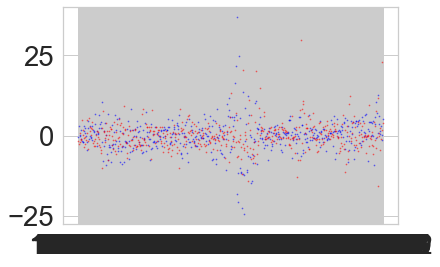

In [72]:
plt.scatter(monthly_factors_pca['date'][:1000], monthly_factors_pca.iloc[:1000,1], c='blue', s=0.5, alpha=0.5)
plt.scatter(monthly_factors_pca['date'][:1000], monthly_factors_pca.iloc[:1000,2],c='red',s=0.5, alpha=0.5)
plt.show()

In [ ]:
monthly_factors_pca = pd.read_csv(path_bucket +'monthly_factors_pca.csv')
monthly_factors_pca = monthly_factors_pca.drop(columns='Unnamed: 0')
monthly_factors_pca.set_index('date',inplace=True)
monthly_factors_pca

regression_df_pca =  monthly_stock_data_wins_quin.groupby('permno').apply(lambda x: pd.concat([x[Y_name], monthly_factors_pca.loc[monthly_factors_pca.index.isin(x.index)]],axis=1))
regression_df_pca.reset_index(inplace=True)
regression_df_pca = regression_df_pca.dropna()
regression_df_pca

# PCA Component Regressions 

In [ ]:
alpha_lasso_pca = Grid_search_function(regression_df_pca,Y_name, 'Lasso')
alpha_lasso_pca = alpha_lasso_pca['alpha']
alpha_lasso_pca

## OLS PCA Regression

In [ ]:
# -0.013874 for 8 pca factors  #-0.013416 for 7 factors   #-0.010931 for 6 factors  #-0.010241 for 5 factors   #-0.009134 for 4 factors   #-0.007775 for 3 factors    # - 0.007016 for 2 factors

In [ ]:
from tqdm import tqdm
tqdm.pandas()

OLS_predictions_pca = regression_df_pca.groupby('permno').progress_apply(lambda x: prediction_function_non_rolling(x,Y_name,'OLS', n_factors_pca, None, None))

OLS_coefs_pca = regression_df_pca.groupby('permno').progress_apply(lambda x: prediction_coefficient_function(x,Y_name,'OLS', n_factors_pca, None, None))

r2_iss = regression_df_pca.groupby('permno').progress_apply(lambda x: r2_iss_function(x,Y_name,'OLS', n_factors_pca, None, None)) 
r2_iss = r2_iss.mean()


OLS_predictions_pca.reset_index(inplace=True)
OLS_predictions_pca= OLS_predictions_pca.drop(OLS_predictions_pca.columns[1],axis=1)
OLS_predictions_pca.columns.values[1] = 'date'
OLS_predictions_pca.columns.values[2] = 'OLS_pred_pca'
OLS_predictions_pca

stock_data = regression_df_pca.groupby('permno').apply(lambda x: x.iloc[int(len(x)*0.8):])
stock_data = stock_data.reset_index(drop=True)
OLS_results_pca = stock_data.loc[:,['permno','date', Y_name]]


OLS_results_pca = pd.merge(OLS_results_pca,OLS_predictions_pca, how='left', on=['permno','date'])
OLS_results_pca = quintile_adapter(OLS_results_pca, 'OLS_pred_pca')
display(OLS_results_pca)

OLS_metrics_pca = calculate_metrics_linear(OLS_results_pca, Y_name,'OLS_pred_pca', 'OLS_metrics', n_factors_pca, r2_oos,r2_iss)
display(OLS_metrics_pca)

################################################# saving ###################################################
OLS_results_pca.to_csv('OLS_results_pca.csv')
file_saver('regression_results/OLS_results_pca.csv','OLS_results_pca.csv')
###############################################################################################################

################################################# saving ########################################################
OLS_coefs_pca.to_csv('OLS_coefs_pca.csv')
file_saver('regression_results/OLS_coefs_pca.csv','OLS_coefs_pca.csv')
#################################################################################################################

################################################# saving ###################################################
OLS_metrics_pca.to_csv('OLS_metrics_pca.csv')
file_saver('regression_results/OLS_metrics_pca.csv','OLS_metrics_pca.csv')
###############################################################################################################

## Lasso PCA Regression 

In [ ]:
 #8 factors # -0.005050   for 1e-03   #0.000601 for 1e-02    #-0.000405 for 1e-01

In [ ]:
from tqdm import tqdm
tqdm.pandas()

Lasso_predictions_pca = regression_df_pca.groupby('permno').progress_apply(lambda x: prediction_function_non_rolling(x,Y_name,'Lasso', n_factors_pca, alpha_lasso_pca, None))

Lasso_coefs_pca = regression_df_pca.groupby('permno').progress_apply(lambda x: prediction_coefficient_function(x,Y_name,'Lasso', n_factors_pca, alpha_lasso_pca, None))

r2_iss = regression_df_pca.groupby('permno').progress_apply(lambda x: r2_iss_function(x,Y_name,'Lasso', n_factors_pca, alpha_lasso_pca, None)) 
r2_iss = r2_iss.mean()

Lasso_predictions_pca.reset_index()
Lasso_predictions_pca.reset_index(inplace=True)
Lasso_predictions_pca= Lasso_predictions_pca.drop(Lasso_predictions_pca.columns[1],axis=1)
Lasso_predictions_pca.columns.values[1] = 'date'
Lasso_predictions_pca.columns.values[2] = 'Lasso_pred_pca'
Lasso_predictions_pca

stock_data = regression_df_pca.groupby('permno').apply(lambda x: x.iloc[int(len(x)*0.8):])
stock_data = stock_data.reset_index(drop=True)
Lasso_results_pca = stock_data.loc[:,['permno','date', Y_name]]

Lasso_results_pca= pd.merge(Lasso_results_pca,Lasso_predictions_pca, how='left', on=['permno','date'])
Lasso_results_pca = quintile_adapter(Lasso_results_pca, 'Lasso_pred_pca')
display(Lasso_results_pca)

Lasso_metrics_pca = calculate_metrics_linear(Lasso_results_pca, Y_name,'Lasso_pred_pca', 'Lasso_metrics', n_factors_pca, r2_oos,r2_iss)
display(Lasso_metrics_pca)

################################################# saving ###################################################
Lasso_results_pca.to_csv('Lasso_results_pca.csv')
file_saver('regression_results/Lasso_results_pca.csv','Lasso_results_pca.csv')
###############################################################################################################

################################################# saving ########################################################
Lasso_coefs_pca.to_csv('Lasso_coefs_pca.csv')
file_saver('regression_results/Lasso_coefs_pca.csv','Lasso_coefs_pca.csv')
#################################################################################################################

################################################# saving ###################################################
Lasso_metrics_pca.to_csv('Lasso_metrics_pca.csv')
file_saver('regression_results/Lasso_metrics_pca.csv','Lasso_metrics_pca.csv')
###############################################################################################################

In [ ]:
plt.boxplot(Lasso_results_pca[Y_name])

In [ ]:
plt.boxplot(Lasso_results_pca['Lasso_pred_pca'])